In [3]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [10]:
prefix='../bench-results-final/'
prefix='../wg-rb-perf'

In [11]:
def update_fontsize(size=12):
    mp.rcParams.update({'font.size': size})

In [12]:
names = ['throughput', 'latency']
pidstat_names = ['timestamp', 'wait', 'used', 'core', 'command']

def import_simple(path, additional_names=[]):
    tmp = pd.read_csv(f"{path}/sock.csv", names=additional_names+names)
    tmp['throughput'] /= 1024
    tmp['latency'] /= 1000
    tmp_cpu = pd.read_csv(f"{path}/pidstat.csv", names=additional_names+pidstat_names)
    tmp_cpu = tmp_cpu.groupby(additional_names + ['core', 'timestamp']).sum(numeric_only=True).reset_index() 
    tmp_cpu = tmp_cpu.groupby(additional_names + ['core']).median(numeric_only=True).reset_index()
    # global_cpu = tmp.groupby(['cpu', 'client']).mean().reset_index()
    tmp['cpu'] = tmp_cpu.mean()['used']
#     tmp['cpu_efficiency'] = tmp['throughput'] / tmp['cpu']
    return tmp

In [13]:
benchmarks = os.listdir(prefix)
list(enumerate(benchmarks))

[(0, 'benchmark-wireguard-vanilla'),
 (1, 'benchmark-wireguard-multi-queue-pool'),
 (2, 'benchmark-wireguard-no-queue'),
 (3, 'benchmark-wireguard-multi-queue-pool-steering'),
 (4, 'benchmark-wireguard-batch')]

In [14]:
vanilla_path = f"{prefix}/{benchmarks[0]}/summary"
vanilla = import_simple(vanilla_path)
vanilla['variant'] = 'VANILLA'
vanilla

FileNotFoundError: [Errno 2] No such file or directory: '../wg-rb-perf/benchmark-wireguard-vanilla/summary/sock.csv'

In [43]:
no_queue_path = f"{prefix}/{benchmarks[1]}/summary"
no_queue = import_simple(no_queue_path)
no_queue['variant'] = 'NO_QUEUE'
no_queue

,throughput,latency,cpu,cpu_efficiency,variant
0,20.854481,88.661387,31.909444,0.653552,NO_QUEUE


In [44]:
batched_path = f"{prefix}/{benchmarks[4]}/summary"
batched = import_simple(batched_path, additional_names=['batch'])
batched['variant'] = 'BATCHED'
batched

,batch,throughput,latency,cpu,cpu_efficiency,variant
0,2,17.200130,90.0547,81.927917,0.209942,BATCHED
1,4,20.688951,52.0277,81.927917,0.252526,BATCHED
2,8,20.698024,54.0868,81.927917,0.252637,BATCHED
3,16,20.654782,55.3418,81.927917,0.252109,BATCHED


In [45]:
mq_path = f"{prefix}/{benchmarks[0]}/summary"
mq = import_simple(mq_path, additional_names=['rings'])
mq['variant'] = 'MULTI_QUEUE'
mq

,rings,throughput,latency,cpu,cpu_efficiency,variant
2,2,18.286656,90.7372,51.30137,0.356456,MULTI_QUEUE
4,4,13.457654,63.6597,51.30137,0.262325,MULTI_QUEUE
8,8,13.057269,152.2170,51.30137,0.254521,MULTI_QUEUE
18,18,6.020771,327.1400,51.30137,0.117361,MULTI_QUEUE


In [46]:
(0.25-0.19)/0.19

0.3157894736842105

In [47]:
mq_steering_path = f"{prefix}/{benchmarks[3]}/summary"
mq_steering = import_simple(mq_steering_path, additional_names=['rings'])
mq_steering['variant'] = 'MULTI_QUEUE'
mq_steering

,rings,throughput,latency,cpu,cpu_efficiency,variant
2,2,19.583487,46.252000,80.701389,0.242666,MULTI_QUEUE
4,4,19.719093,20.865600,80.701389,0.244346,MULTI_QUEUE
8,8,20.262790,28.868865,80.701389,0.251084,MULTI_QUEUE
18,18,20.844239,91.517054,80.701389,0.258288,MULTI_QUEUE


# Batched

In [48]:
def plot_(df, x, y, xlabel, ylabel, normal_value, text_offset=0, text_spacing=.1, ylim=None, logy=False, saveas=None):
    with plt.style.context(['science', 'ieee']):
        update_
        ax = df.plot.bar(x=x, y=y, grid=True, ylim=ylim, logy=logy,
                         ylabel=ylabel, xlabel=xlabel,
                        legend=None)
        ax.axhline(y=normal_value, color='red', linestyle='--', label='vanilla')
        ax.annotate(
            f'VANILLA', 
            xy=(2, normal_value), 
            xytext=(text_offset, normal_value+text_spacing), fontsize=8, color='red'
    #                     textcoords='offset point'
        )
        plt.xticks(rotation=0)
        if saveas is not None:
            plt.savefig(saveas, dpi=300)
        else:
            plt.show()
    return df

,batch,throughput,latency,cpu,cpu_efficiency,variant
0,2,17.200130,90.0547,81.927917,0.209942,BATCHED
1,4,20.688951,52.0277,81.927917,0.252526,BATCHED
2,8,20.698024,54.0868,81.927917,0.252637,BATCHED
3,16,20.654782,55.3418,81.927917,0.252109,BATCHED


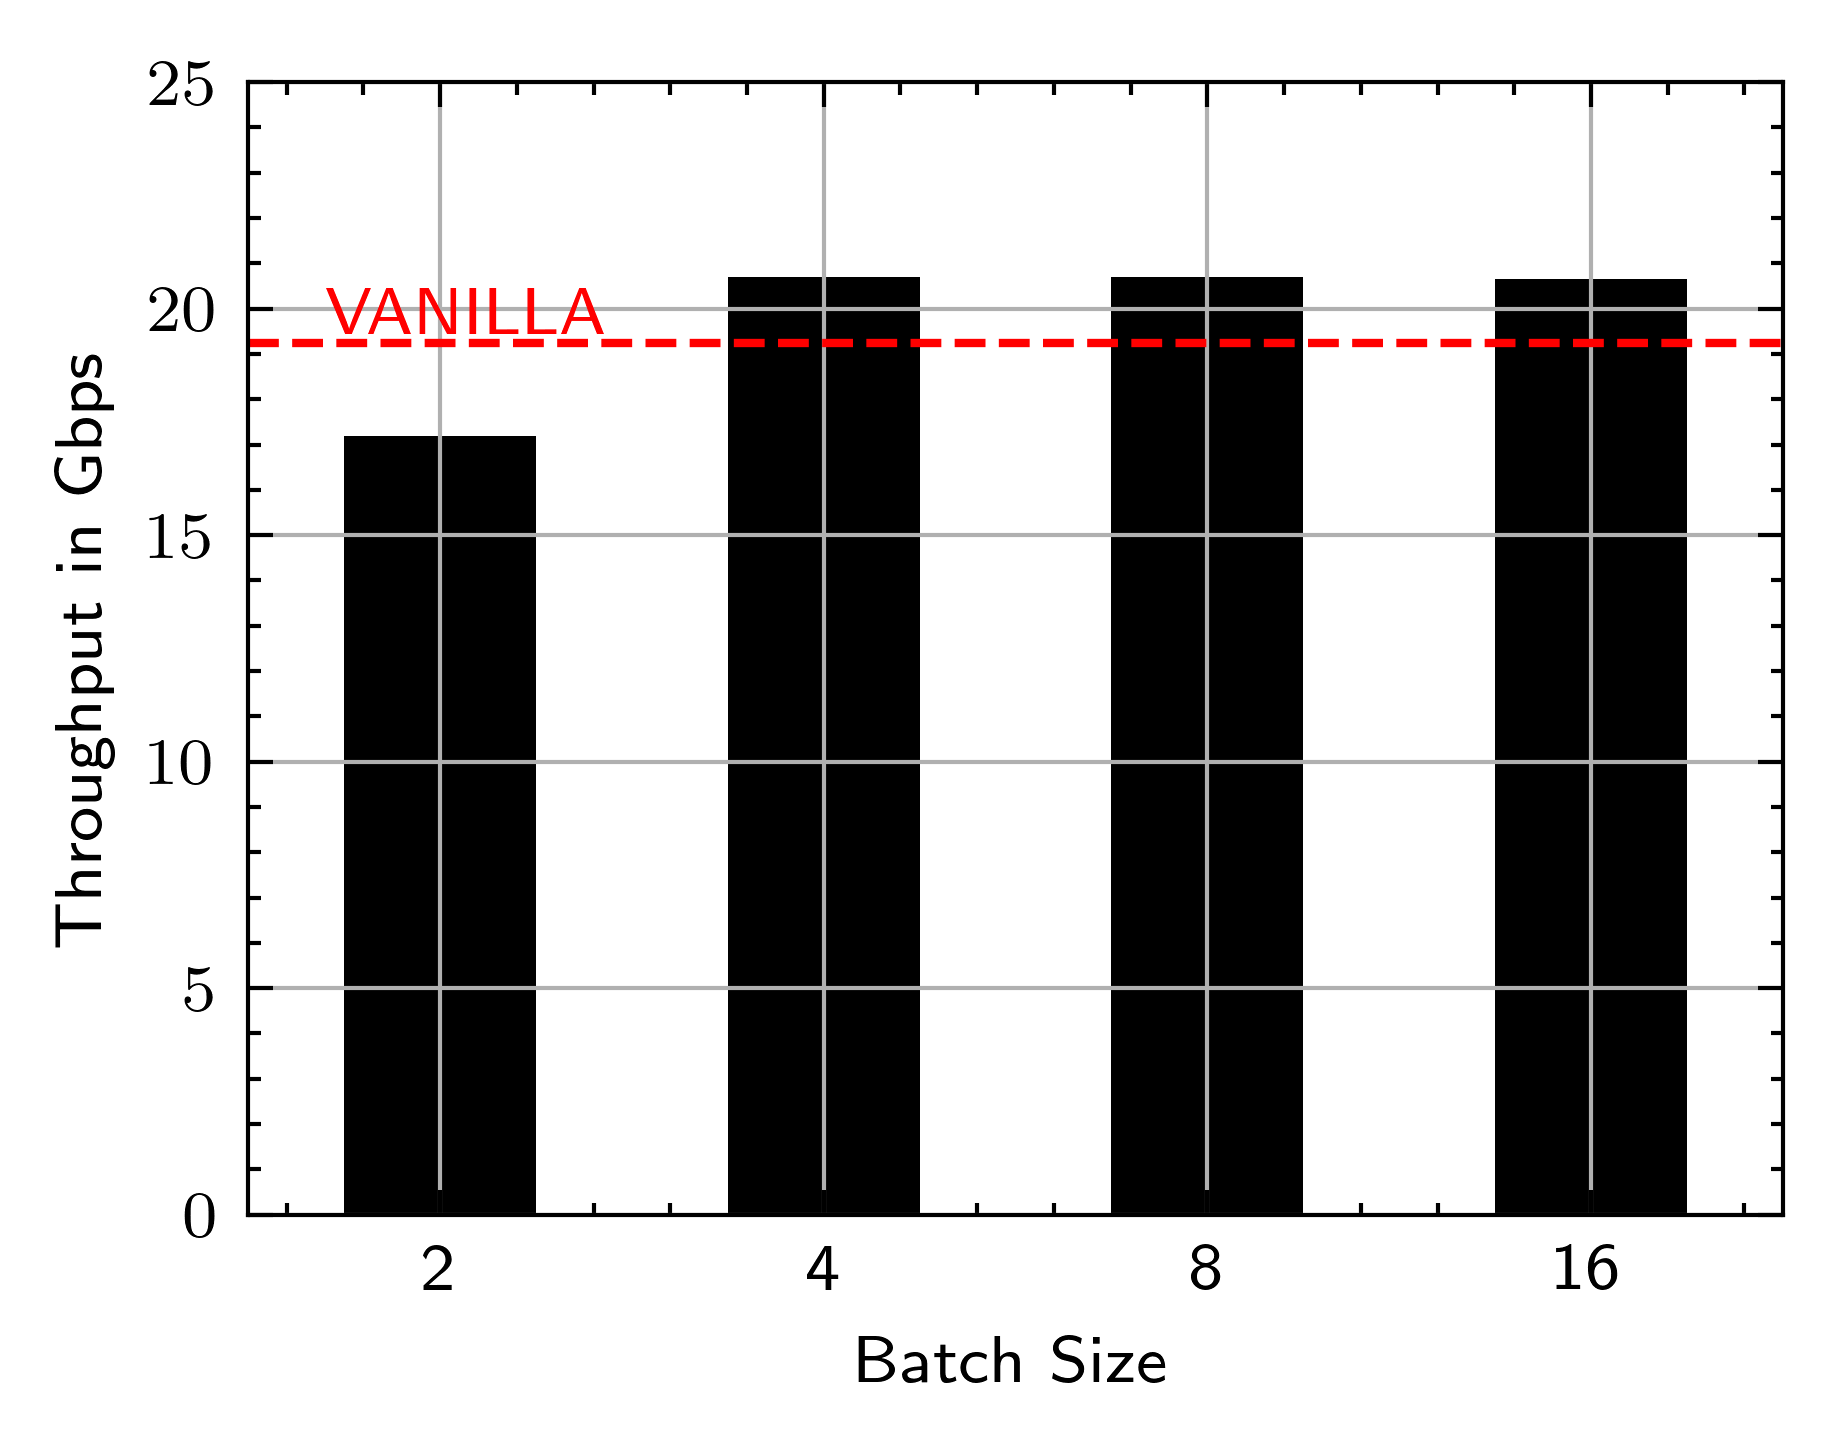

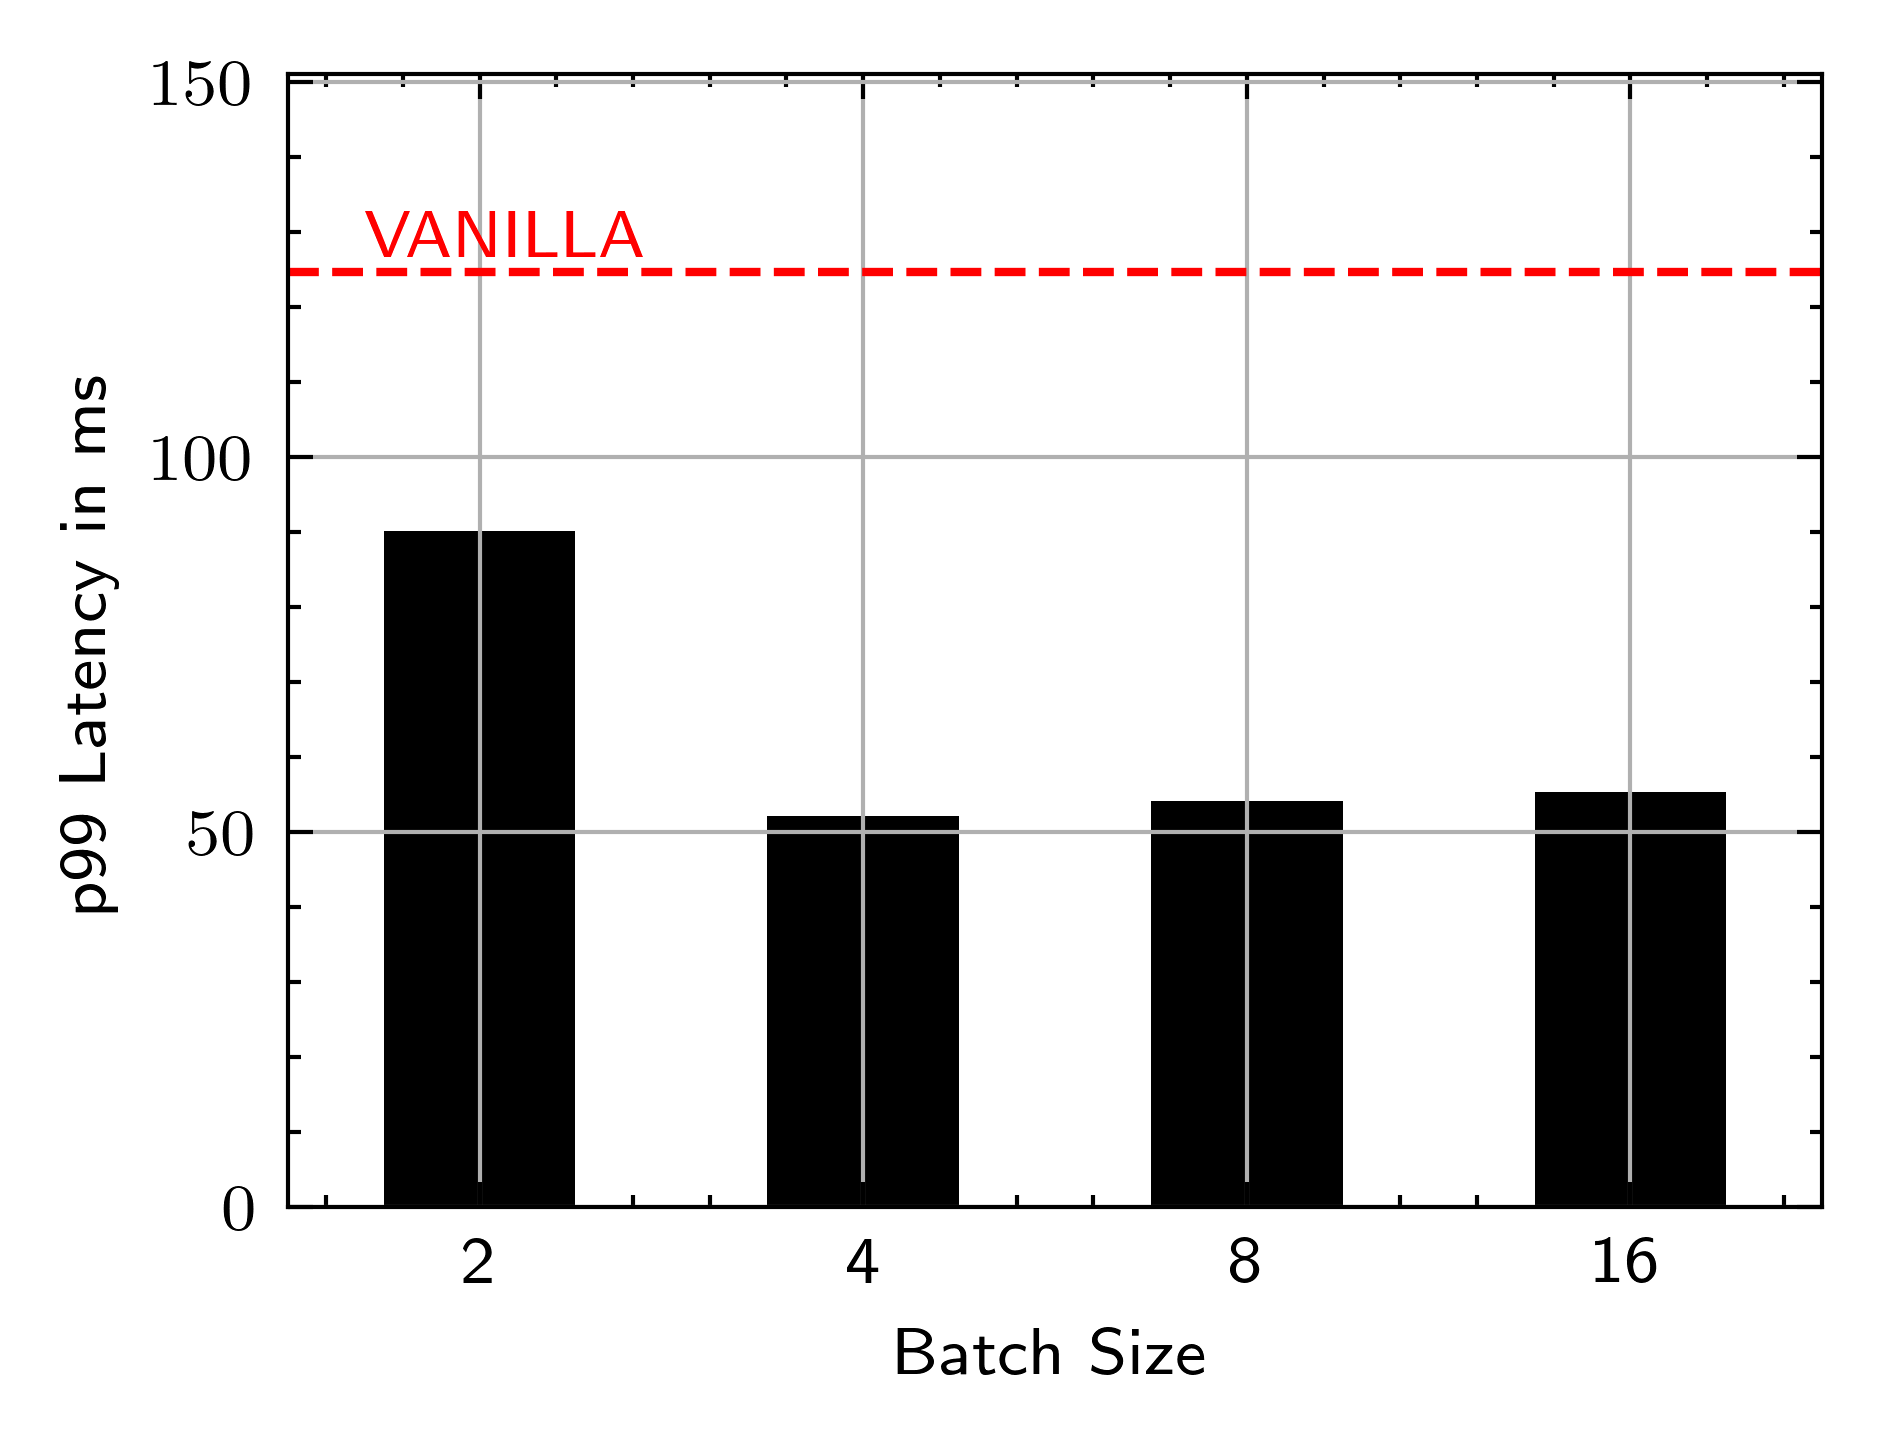

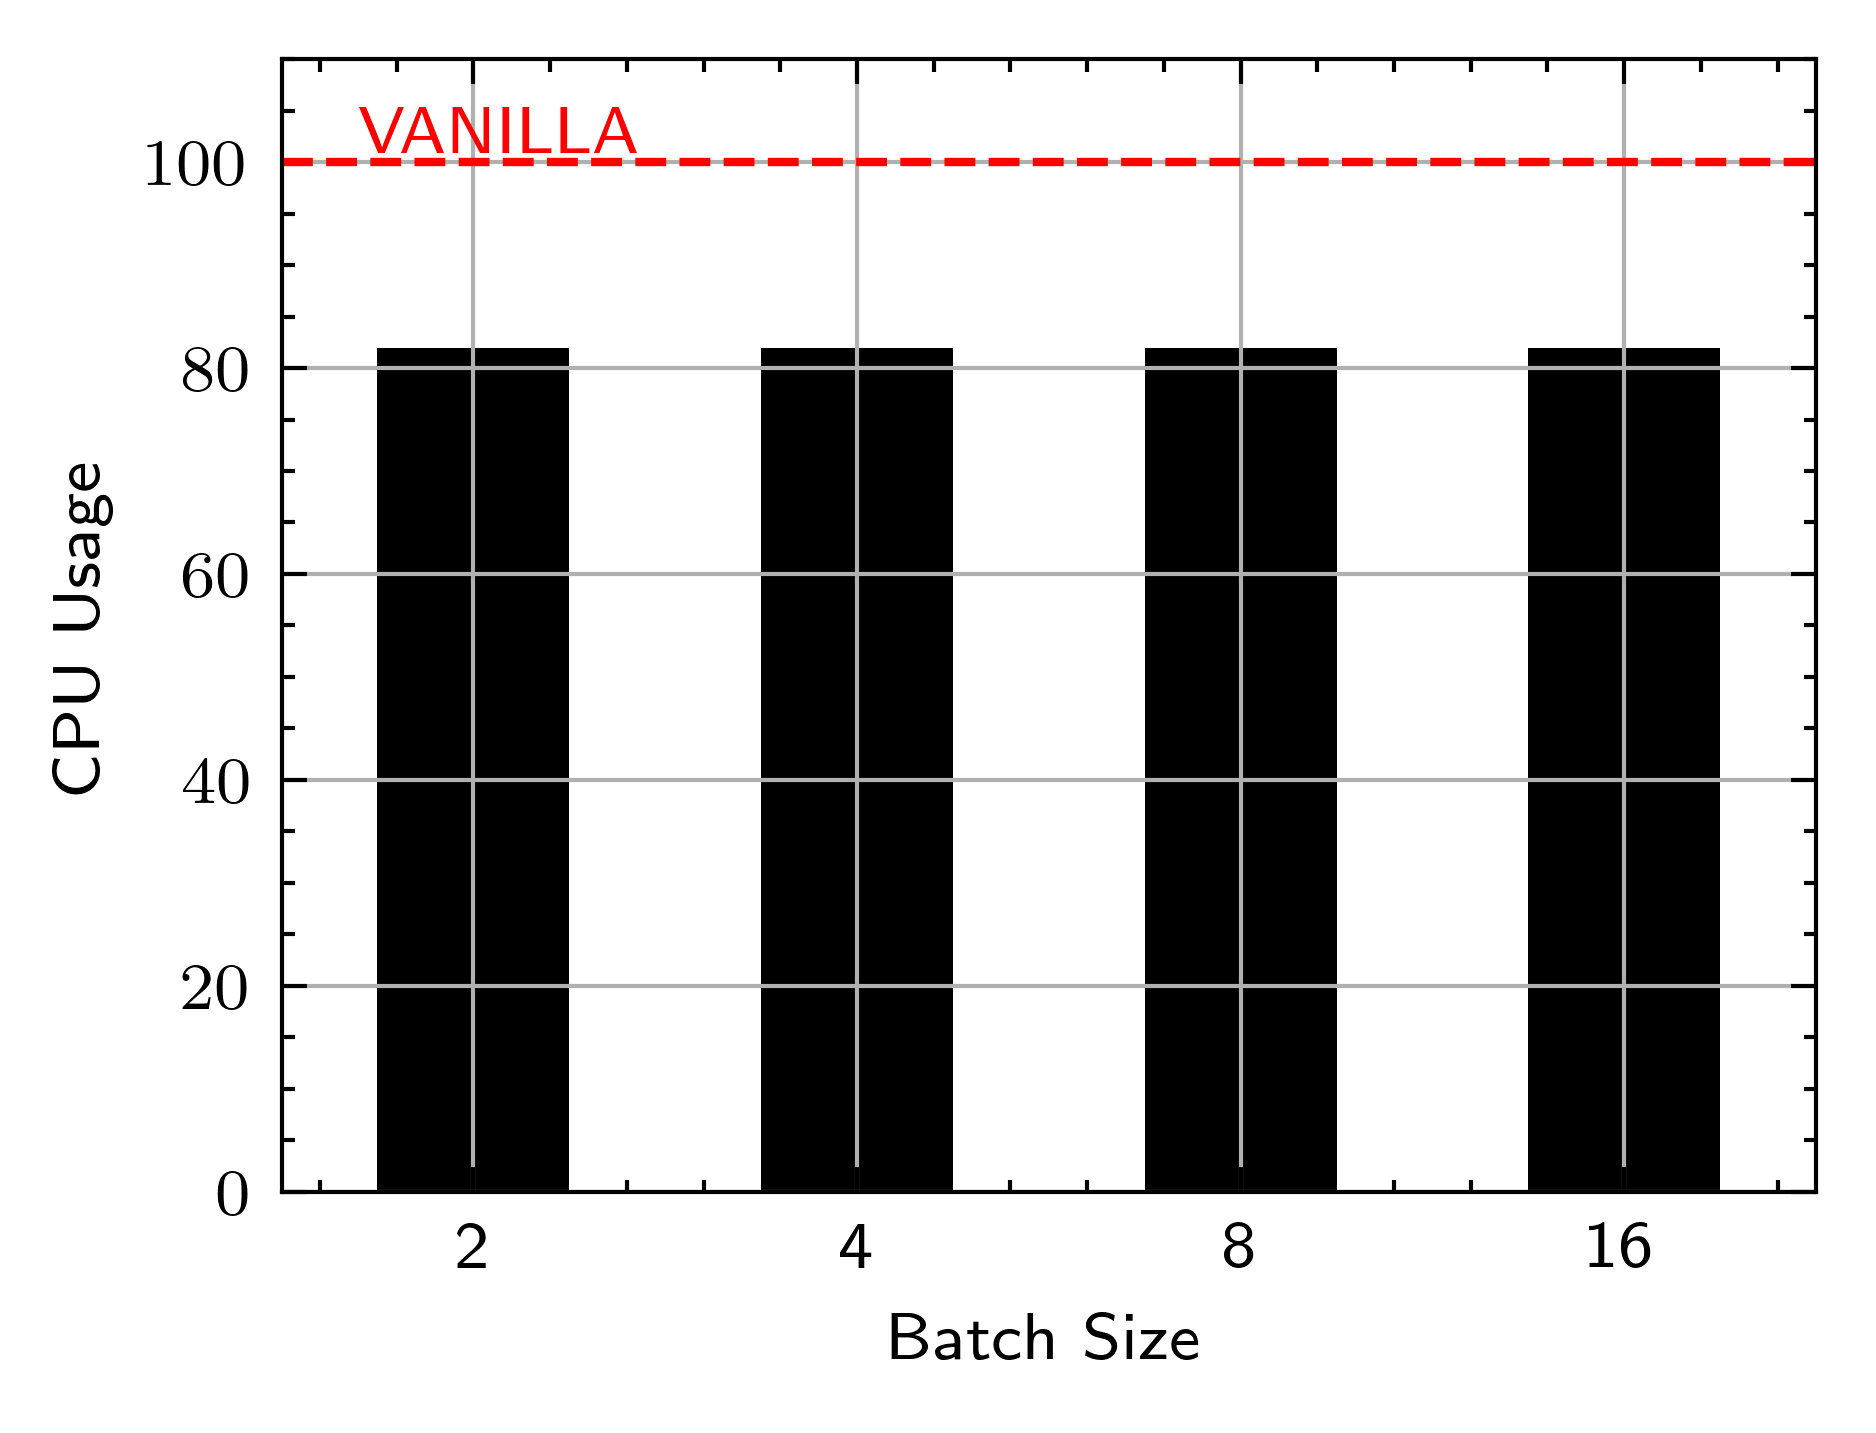

In [49]:
df = batched
x = 'batch'

plot_(
    df, x=x, y='throughput', ylim=[0, 25],
    xlabel='Batch Size', ylabel='Throughput in Gbps',
    normal_value=vanilla['throughput'].iloc[0],
    text_spacing=.2, text_offset=-0.3, saveas='../graphs/batch-tp.pdf',
)

plot_(
    df, x=x, y='latency', ylim=[0, 151],
    xlabel='Batch Size', ylabel='p99 Latency in ms',
    normal_value=vanilla['latency'].iloc[0],
    text_spacing=2, text_offset=-0.3, saveas='../graphs/batch-p99.pdf',
)

metric = 'cpu'
plot_(
    df, x=x, y=metric, ylim=[0, 110],
    xlabel='Batch Size', ylabel='CPU Usage',
    normal_value=vanilla[metric].iloc[0],
    text_spacing=1, text_offset=-0.3, saveas='../graphs/batch-cpu.pdf',
)

# Multi_Queue

,rings,throughput,latency,cpu,cpu_efficiency,variant
2,2,18.286656,90.7372,51.30137,0.356456,MULTI_QUEUE
4,4,13.457654,63.6597,51.30137,0.262325,MULTI_QUEUE
8,8,13.057269,152.2170,51.30137,0.254521,MULTI_QUEUE
18,18,6.020771,327.1400,51.30137,0.117361,MULTI_QUEUE


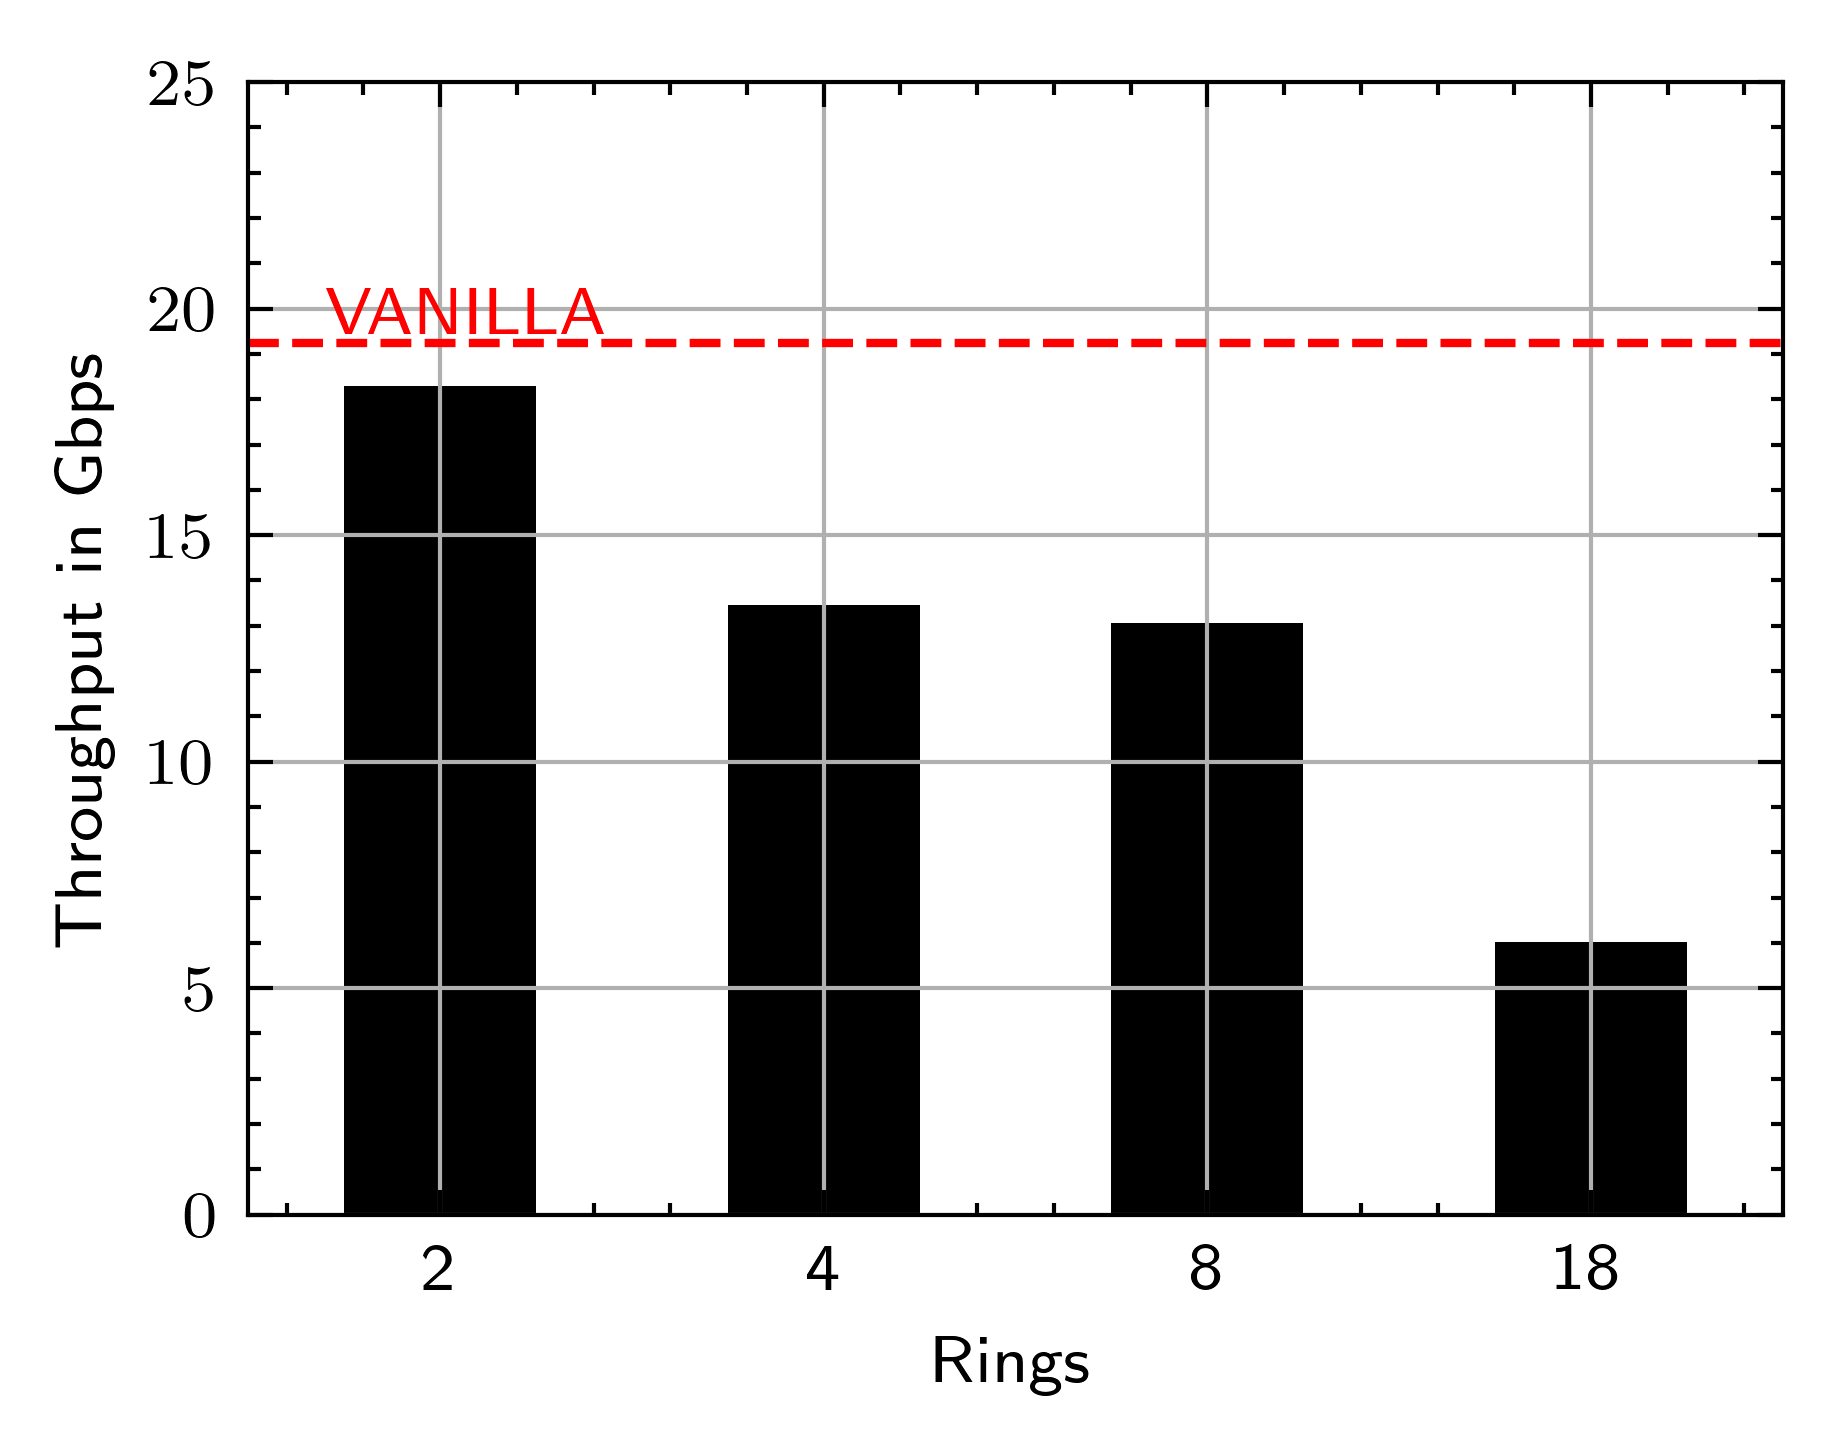

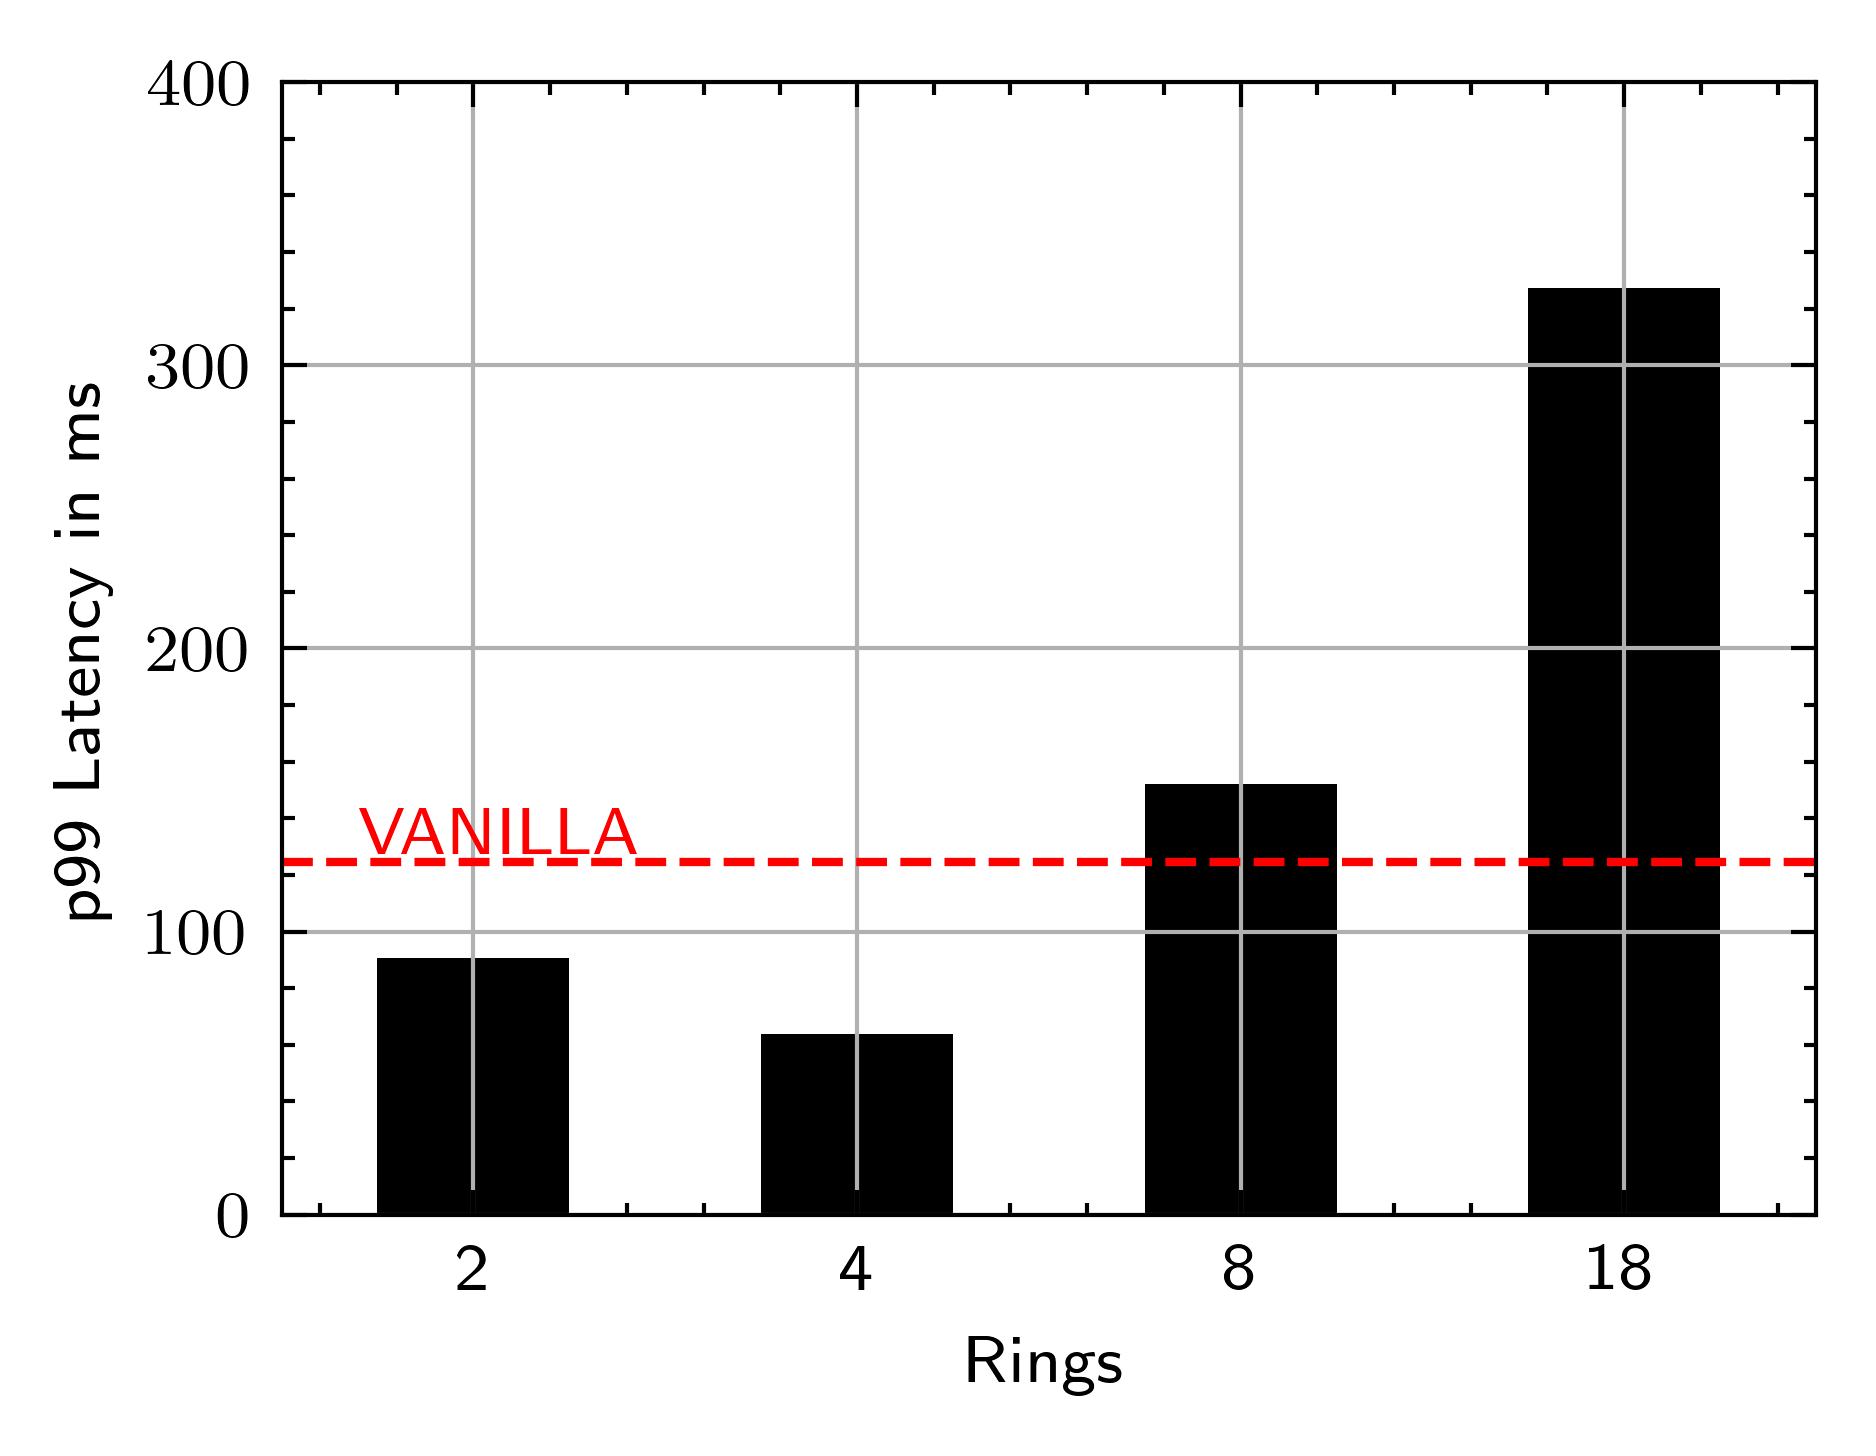

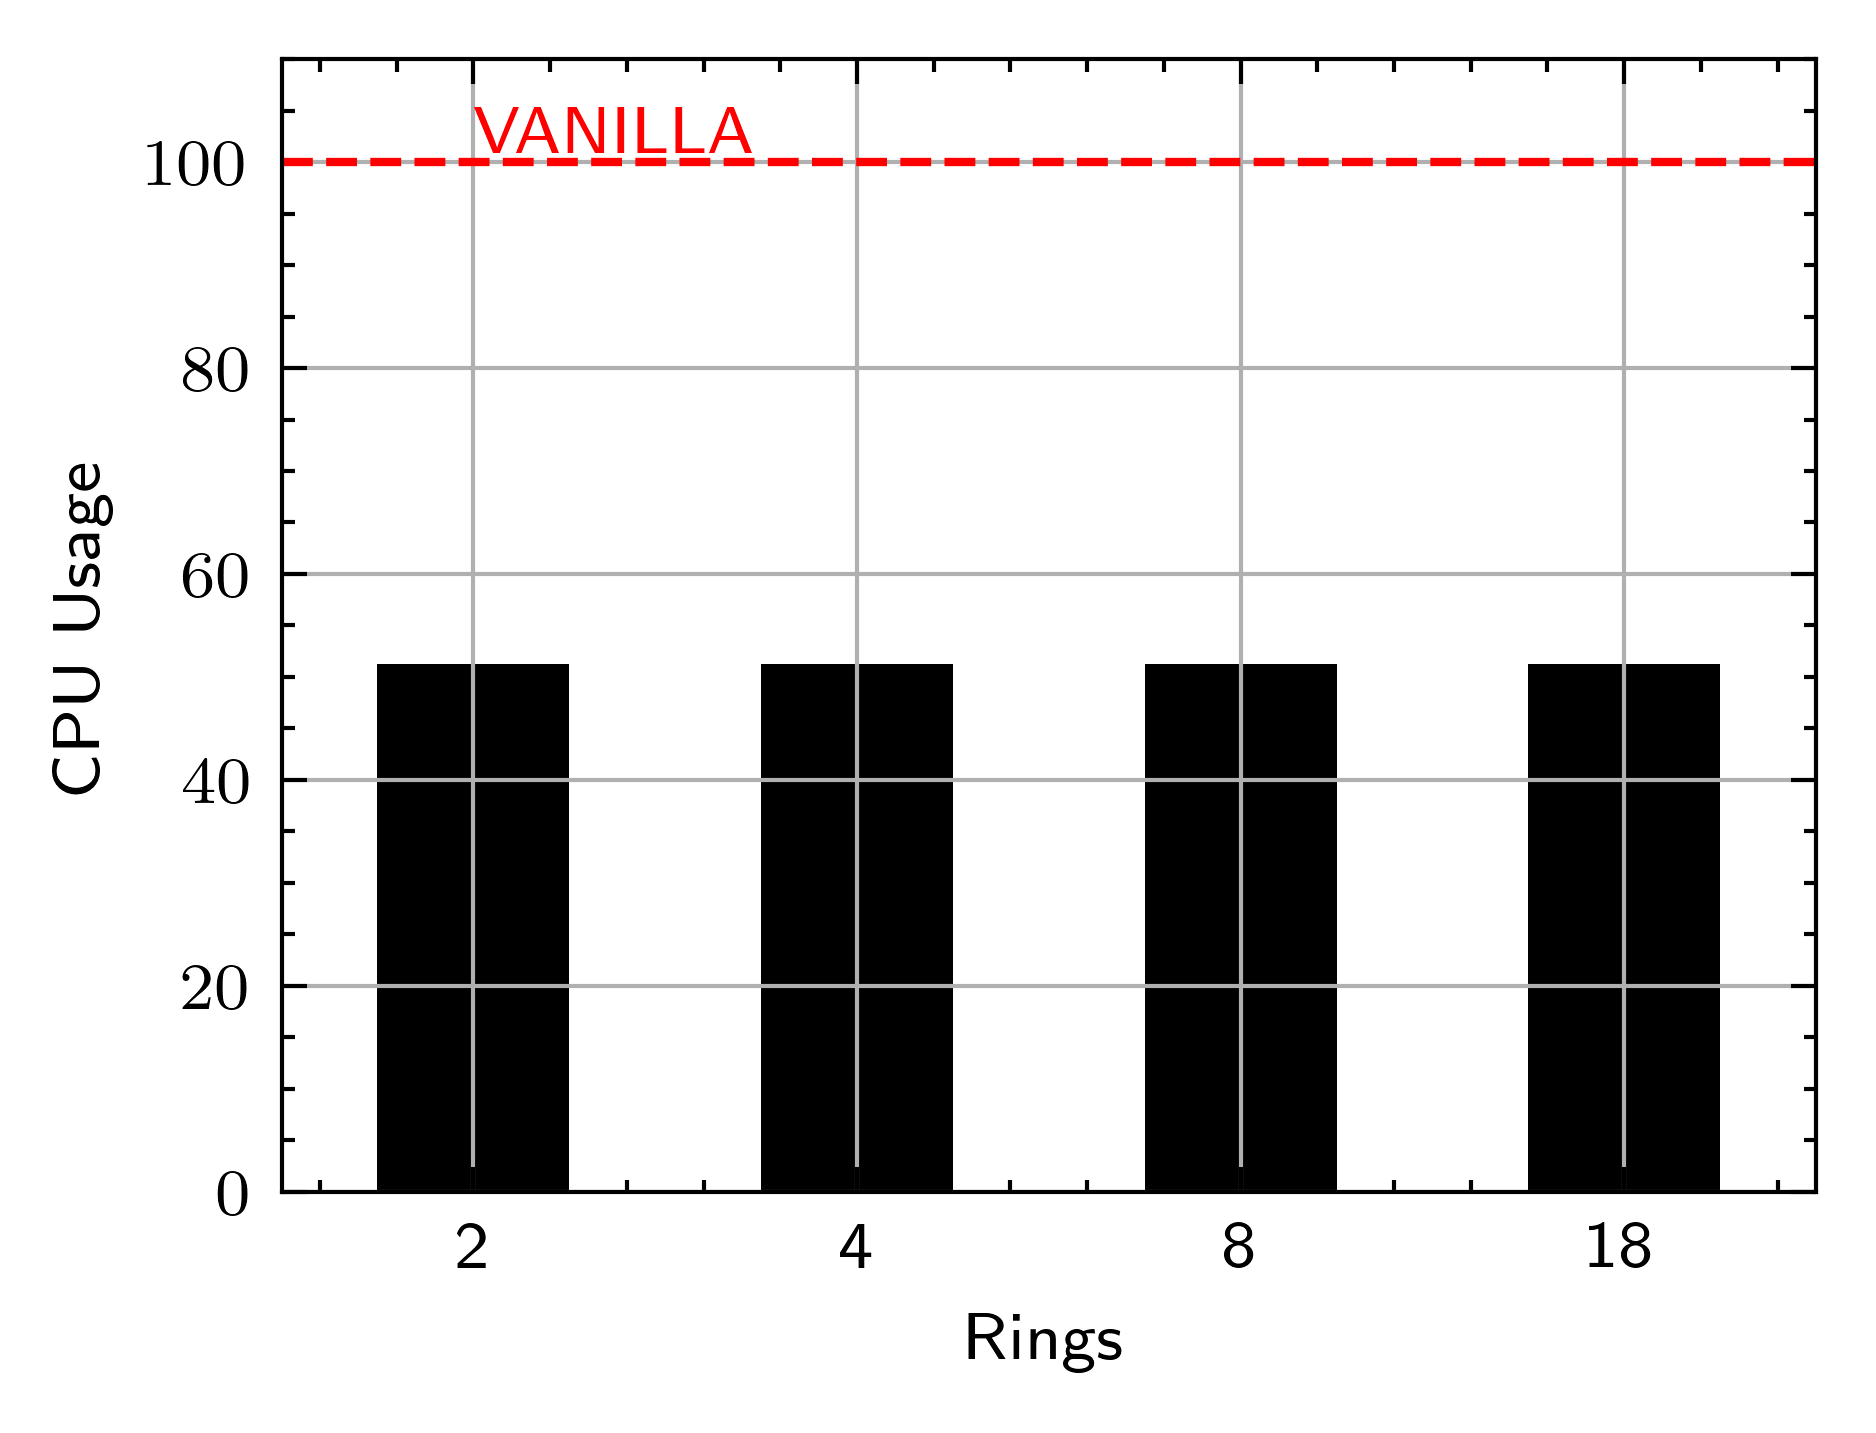

In [50]:
df = mq
x = 'rings'

plot_(
    df, x=x, y='throughput', ylim=[0, 25],
    xlabel='Rings', ylabel='Throughput in Gbps',
    normal_value=vanilla['throughput'].iloc[0],
    text_spacing=.2, text_offset=-0.3, saveas='../graphs/mq-tp.pdf',
)

plot_(
    df, x=x, y='latency', ylim=[0, 400],
    xlabel='Rings', ylabel='p99 Latency in ms',
    normal_value=vanilla['latency'].iloc[0],
    text_spacing=3, text_offset=-0.3, saveas='../graphs/mq-p99.pdf',
)

metric = 'cpu'
plot_(
    df, x=x, y=metric, ylim=[0, 110],
    xlabel='Rings', ylabel='CPU Usage',
    normal_value=vanilla[metric].iloc[0],
    text_spacing=1, text_offset=0, saveas='../graphs/mq-cpu.pdf',
)

# Multi Queue Steering

,rings,throughput,latency,cpu,cpu_efficiency,variant
2,2,19.583487,46.252000,80.701389,0.242666,MULTI_QUEUE
4,4,19.719093,20.865600,80.701389,0.244346,MULTI_QUEUE
8,8,20.262790,28.868865,80.701389,0.251084,MULTI_QUEUE
18,18,20.844239,91.517054,80.701389,0.258288,MULTI_QUEUE


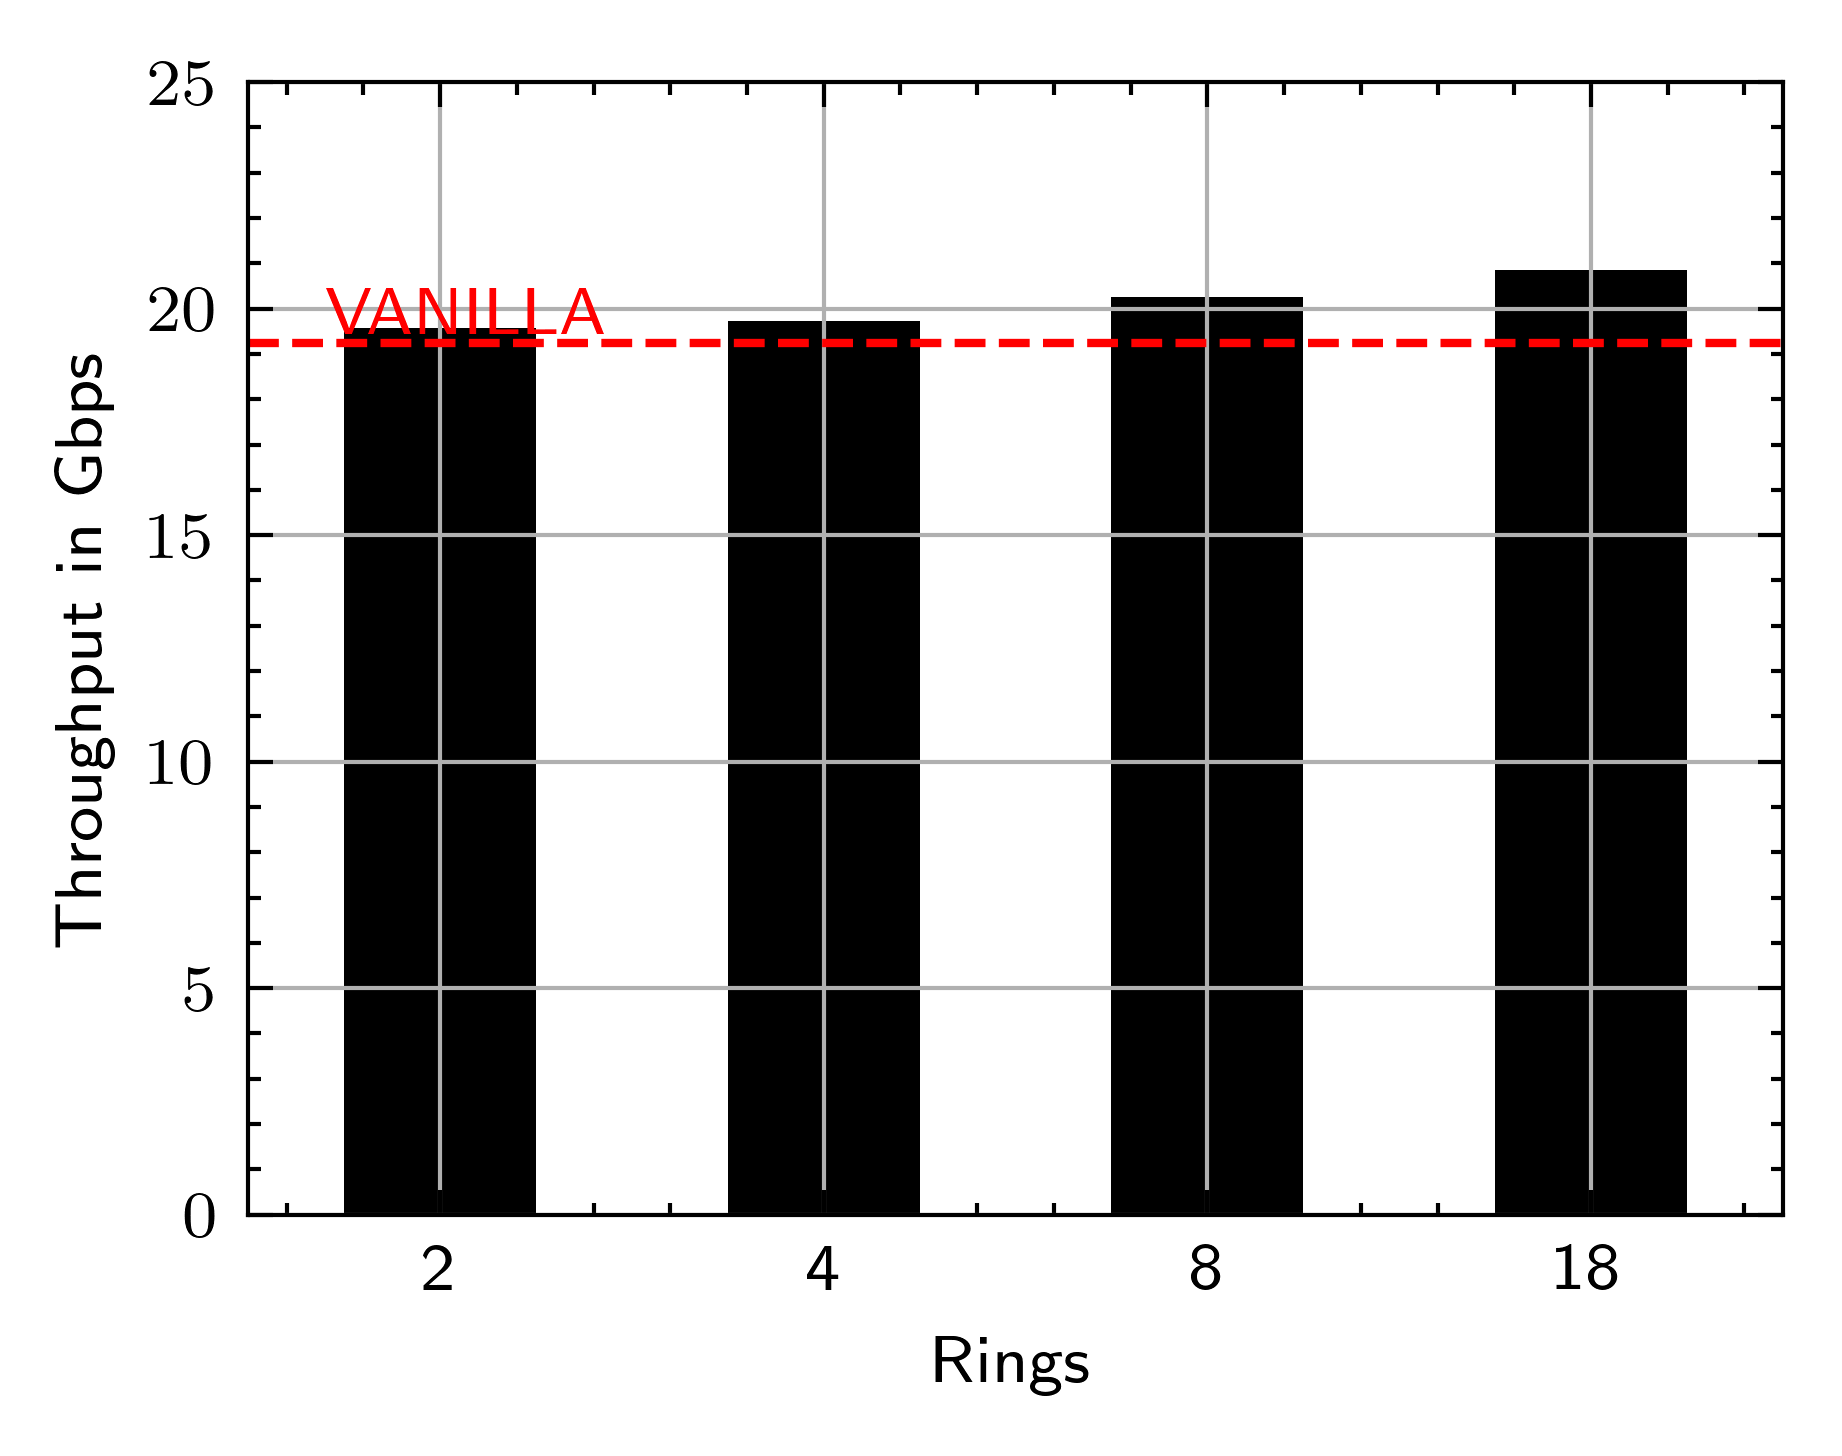

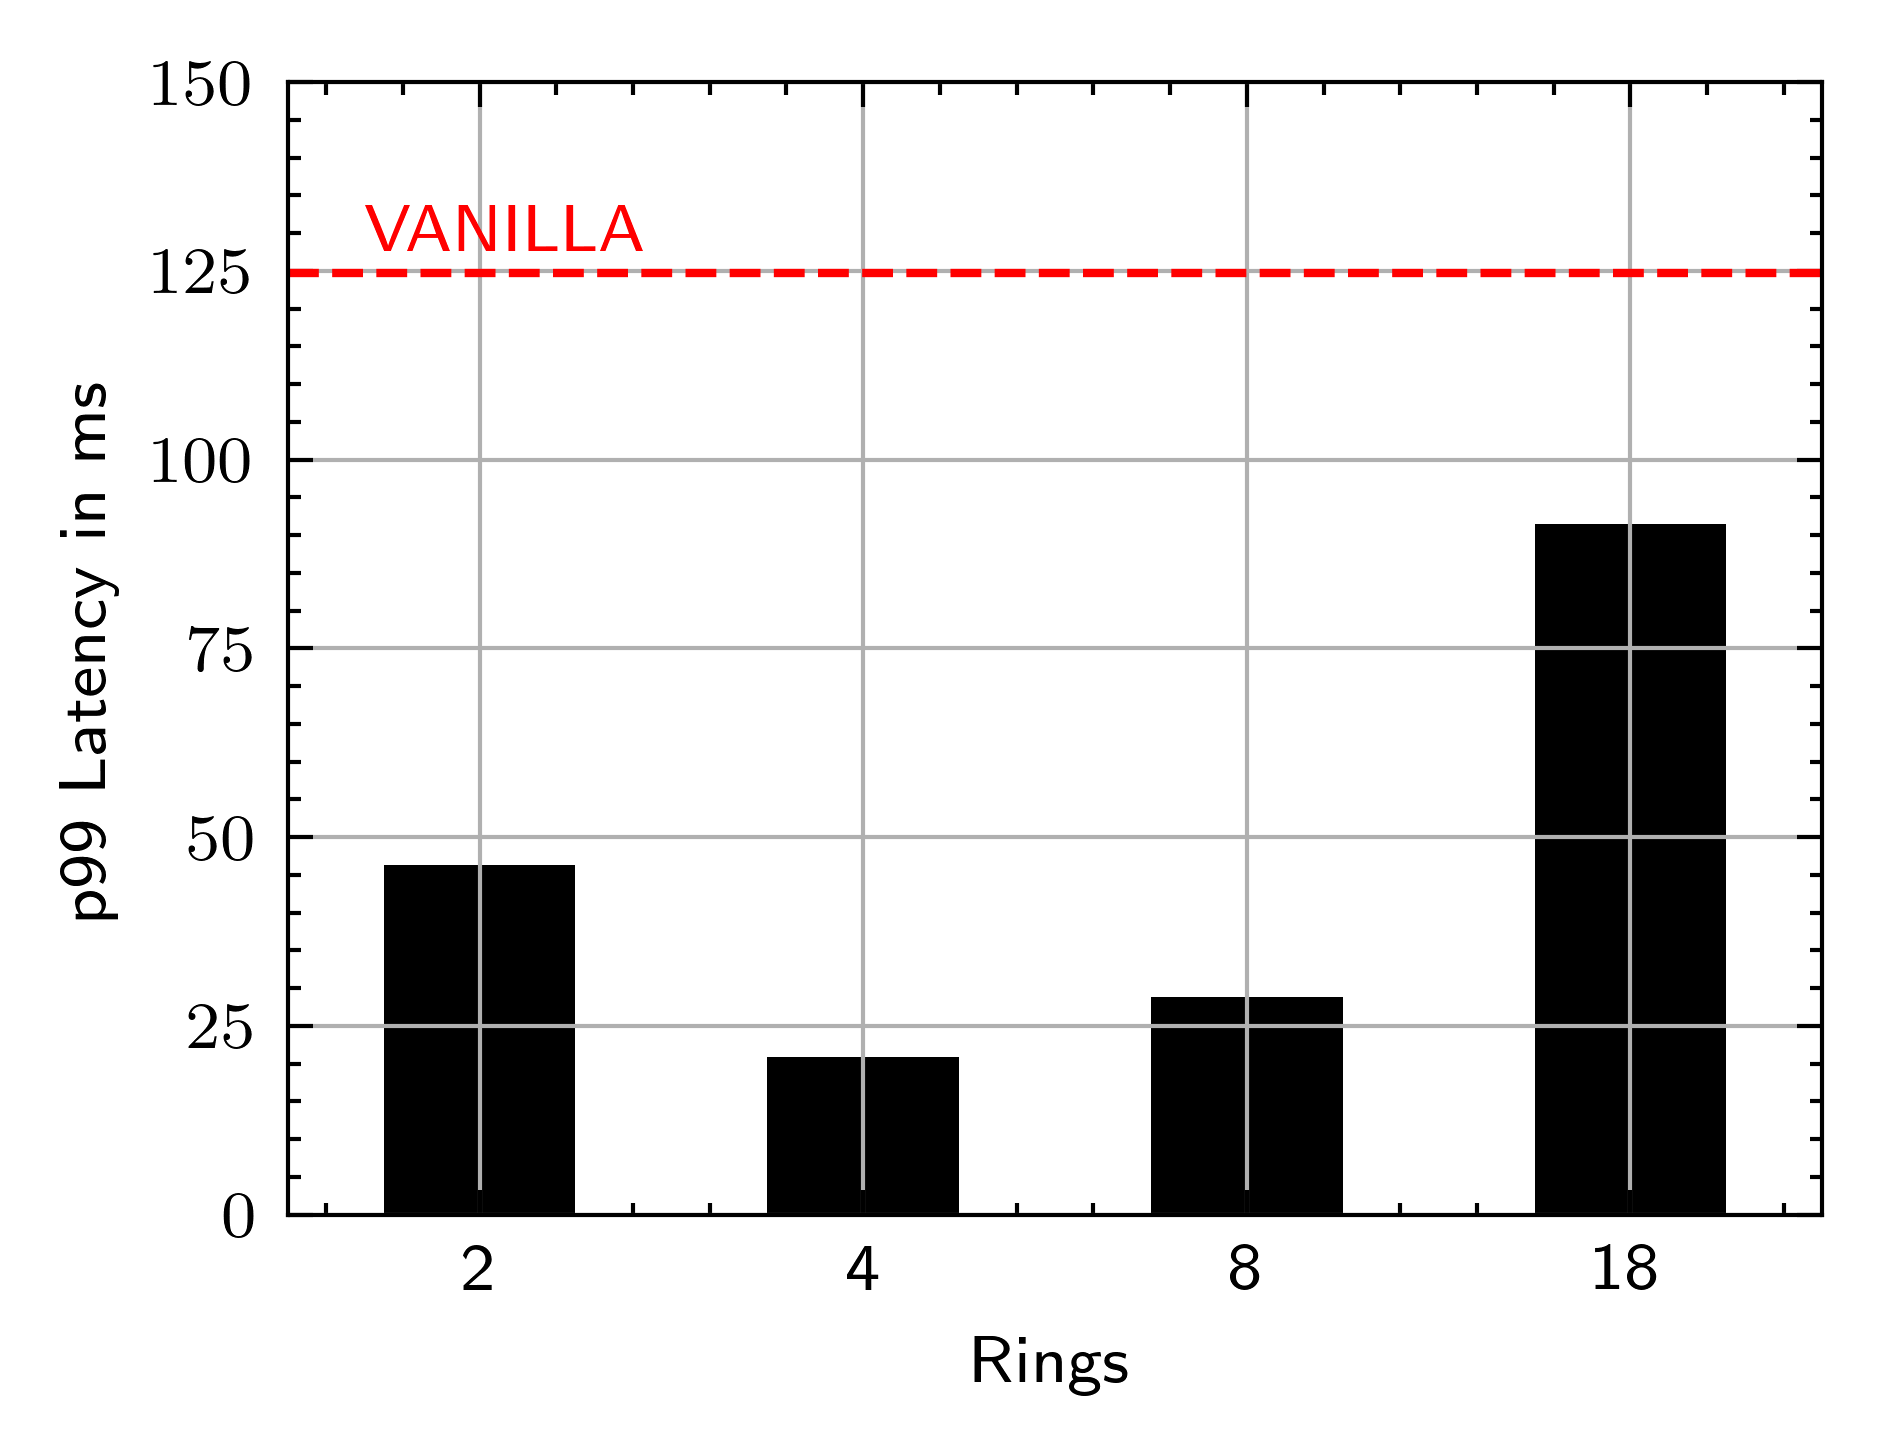

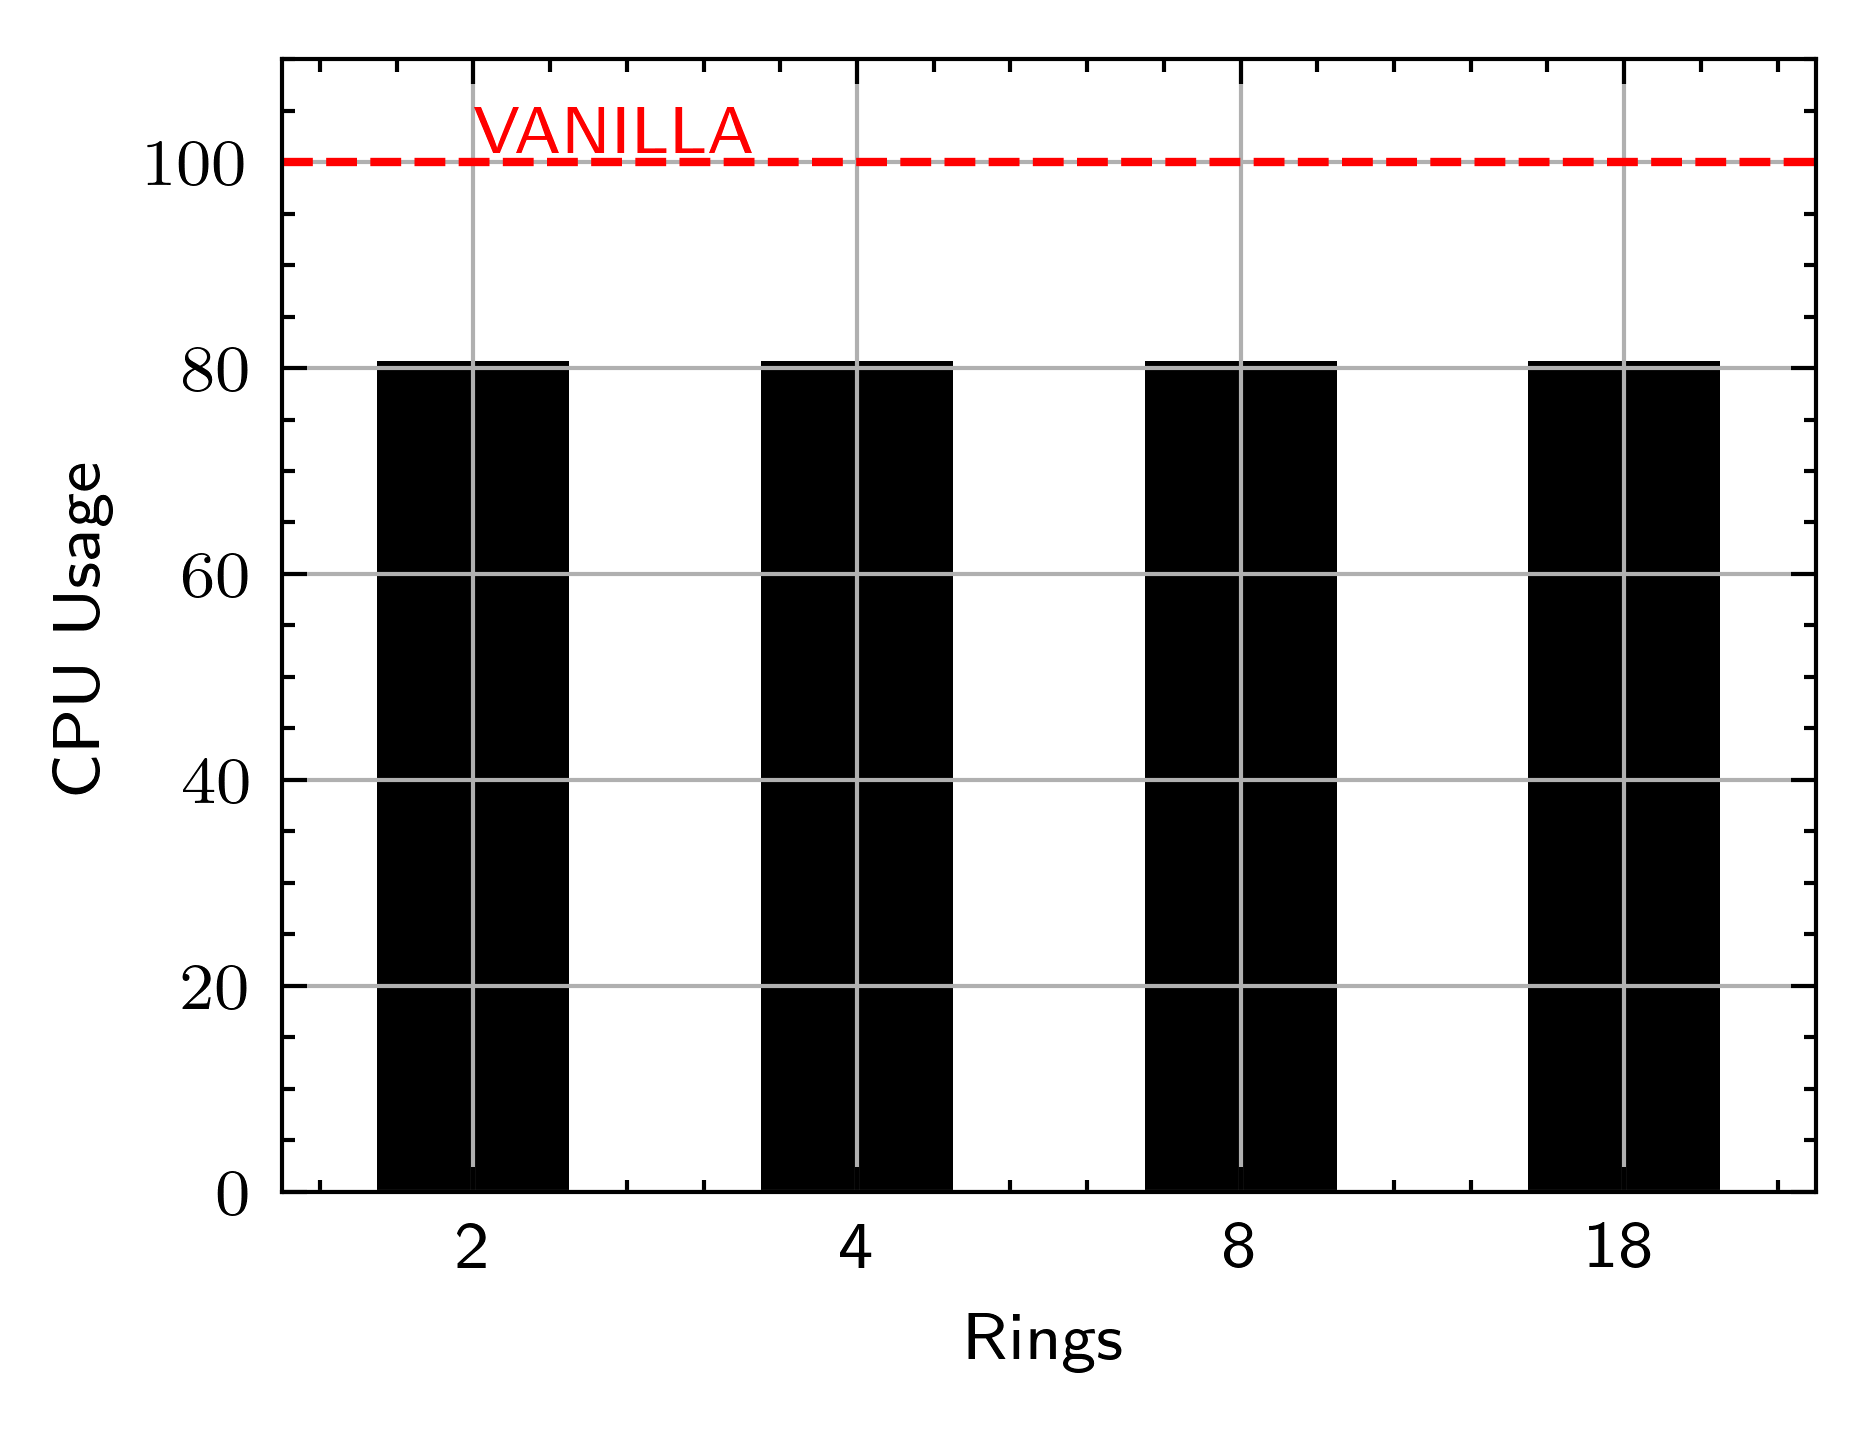

In [51]:
df = mq_steering
x = 'rings'

plot_(
    df, x=x, y='throughput', ylim=[0, 25],
    xlabel='Rings', ylabel='Throughput in Gbps',
    normal_value=vanilla['throughput'].iloc[0],
    text_spacing=.2, text_offset=-0.3, saveas='../graphs/mq-steer-tp.pdf',
)

plot_(
    df, x=x, y='latency', ylim=[0, 150],
    xlabel='Rings', ylabel='p99 Latency in ms',
    normal_value=vanilla['latency'].iloc[0],
    text_spacing=3, text_offset=-0.3, saveas='../graphs/mq-steer-p99.pdf',
)

metric = 'cpu'
plot_(
    df, x=x, y=metric, ylim=[0, 110],
    xlabel='Rings', ylabel='CPU Usage',
    normal_value=vanilla[metric].iloc[0],
    text_spacing=1, text_offset=0, saveas='../graphs/mq-steer-cpu.pdf',
)

# Comparison of bests

In [52]:
mq_best = mq_steering[mq_steering.rings == 4]
batched_best = batched[batched.batch == 4]

In [53]:
mq_best

,rings,throughput,latency,cpu,cpu_efficiency,variant
4,4,19.719093,20.8656,80.701389,0.244346,MULTI_QUEUE


In [54]:
df = pd.concat(
    [vanilla, no_queue, batched_best, mq_best],
    axis=0
).reset_index()

In [55]:
df

,index,throughput,latency,cpu,cpu_efficiency,variant,batch,rings
0,0,19.237766,124.675000,100.000000,0.192378,VANILLA,NaN,NaN
1,0,20.854481,88.661387,31.909444,0.653552,NO_QUEUE,NaN,NaN
2,1,20.688951,52.027700,81.927917,0.252526,BATCHED,4.0,NaN
3,4,19.719093,20.865600,80.701389,0.244346,MULTI_QUEUE,NaN,4.0


In [56]:
0.653552 / 0.252526

2.5880582593475525

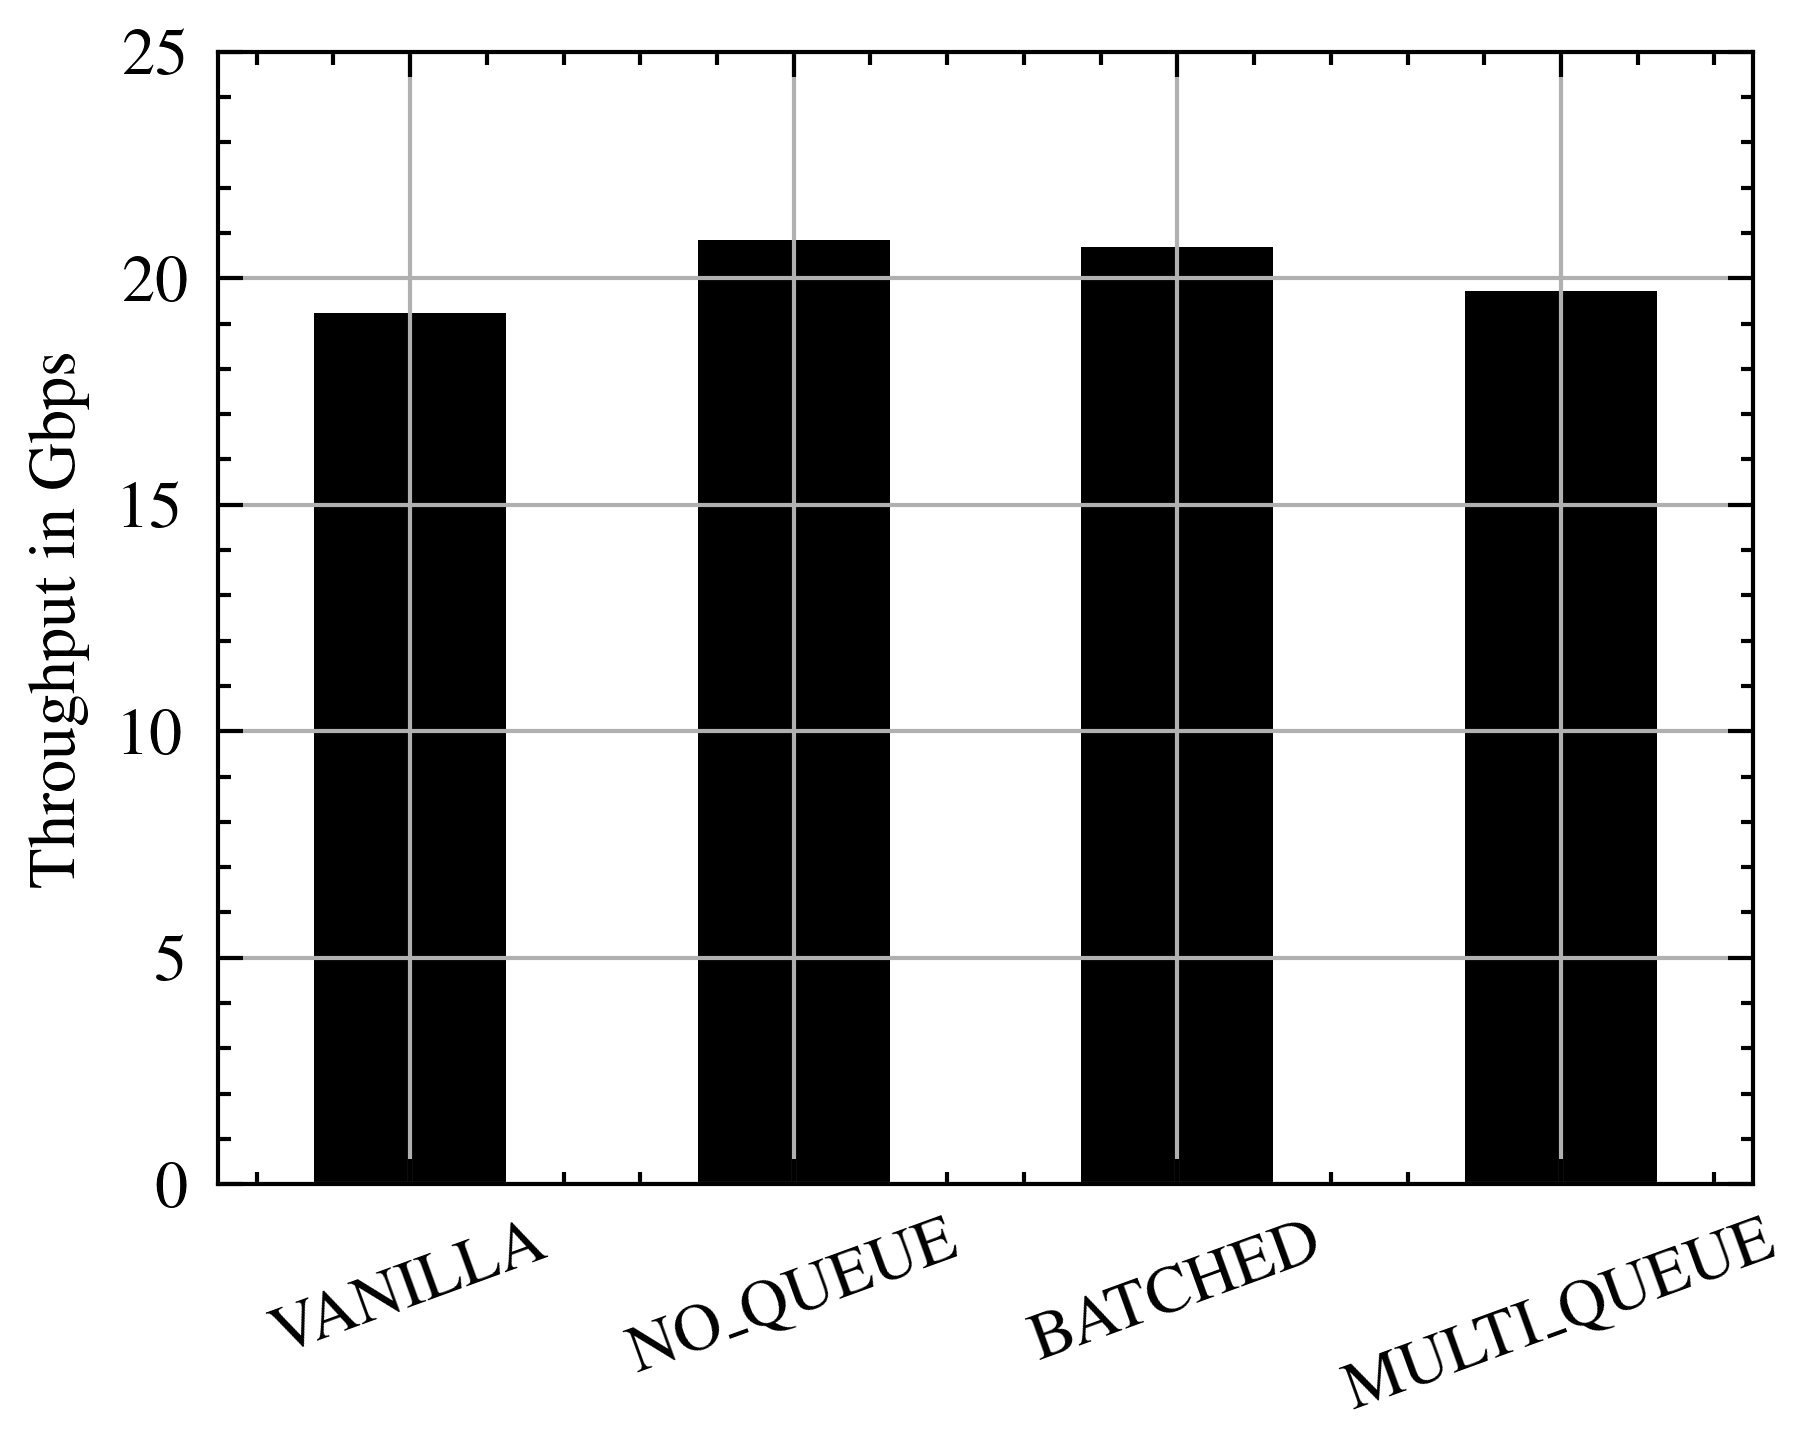

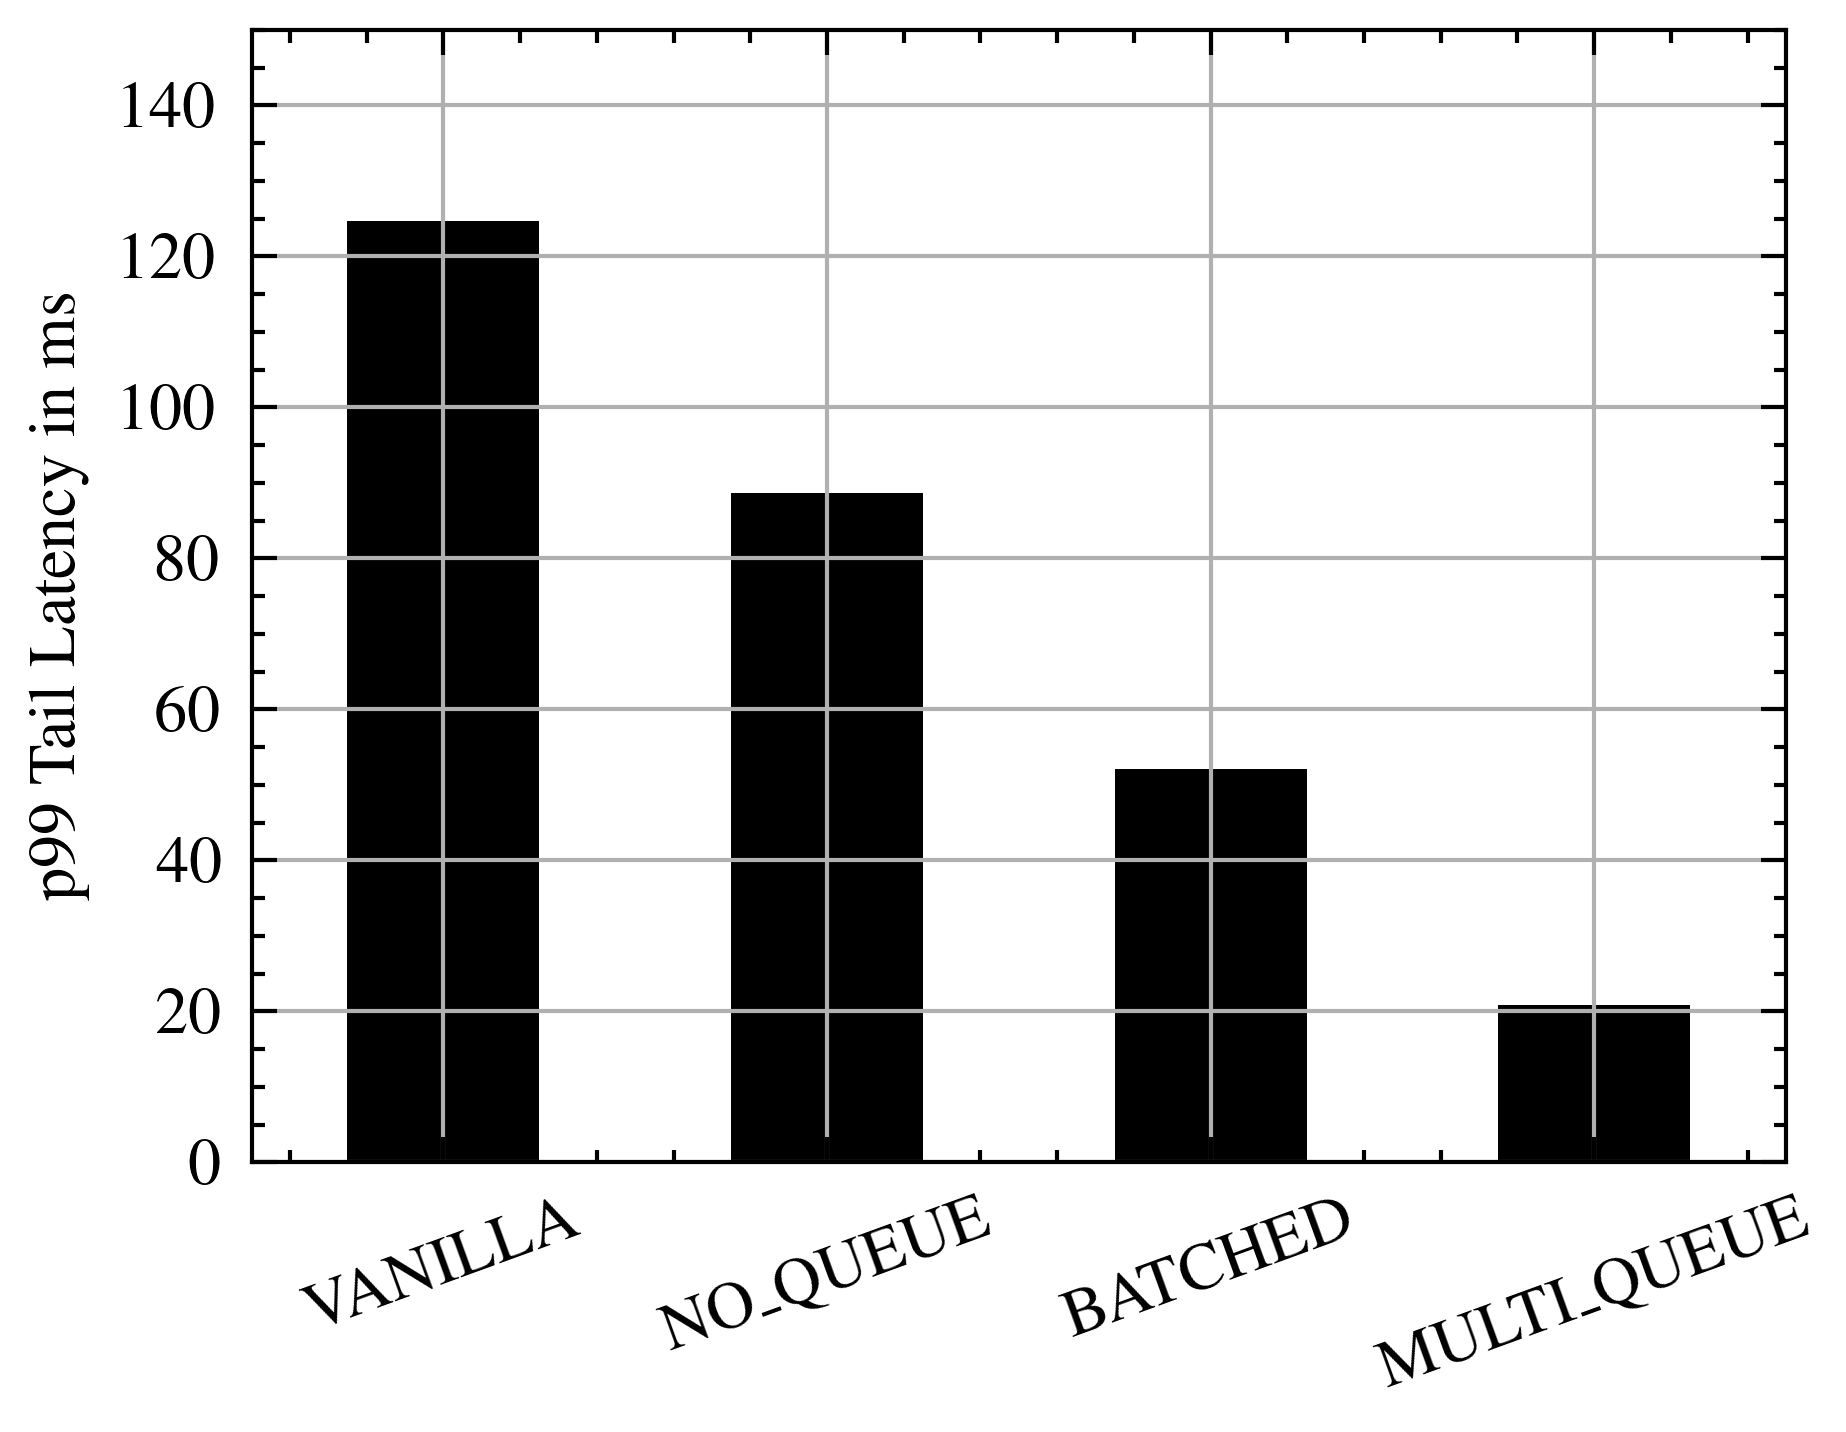

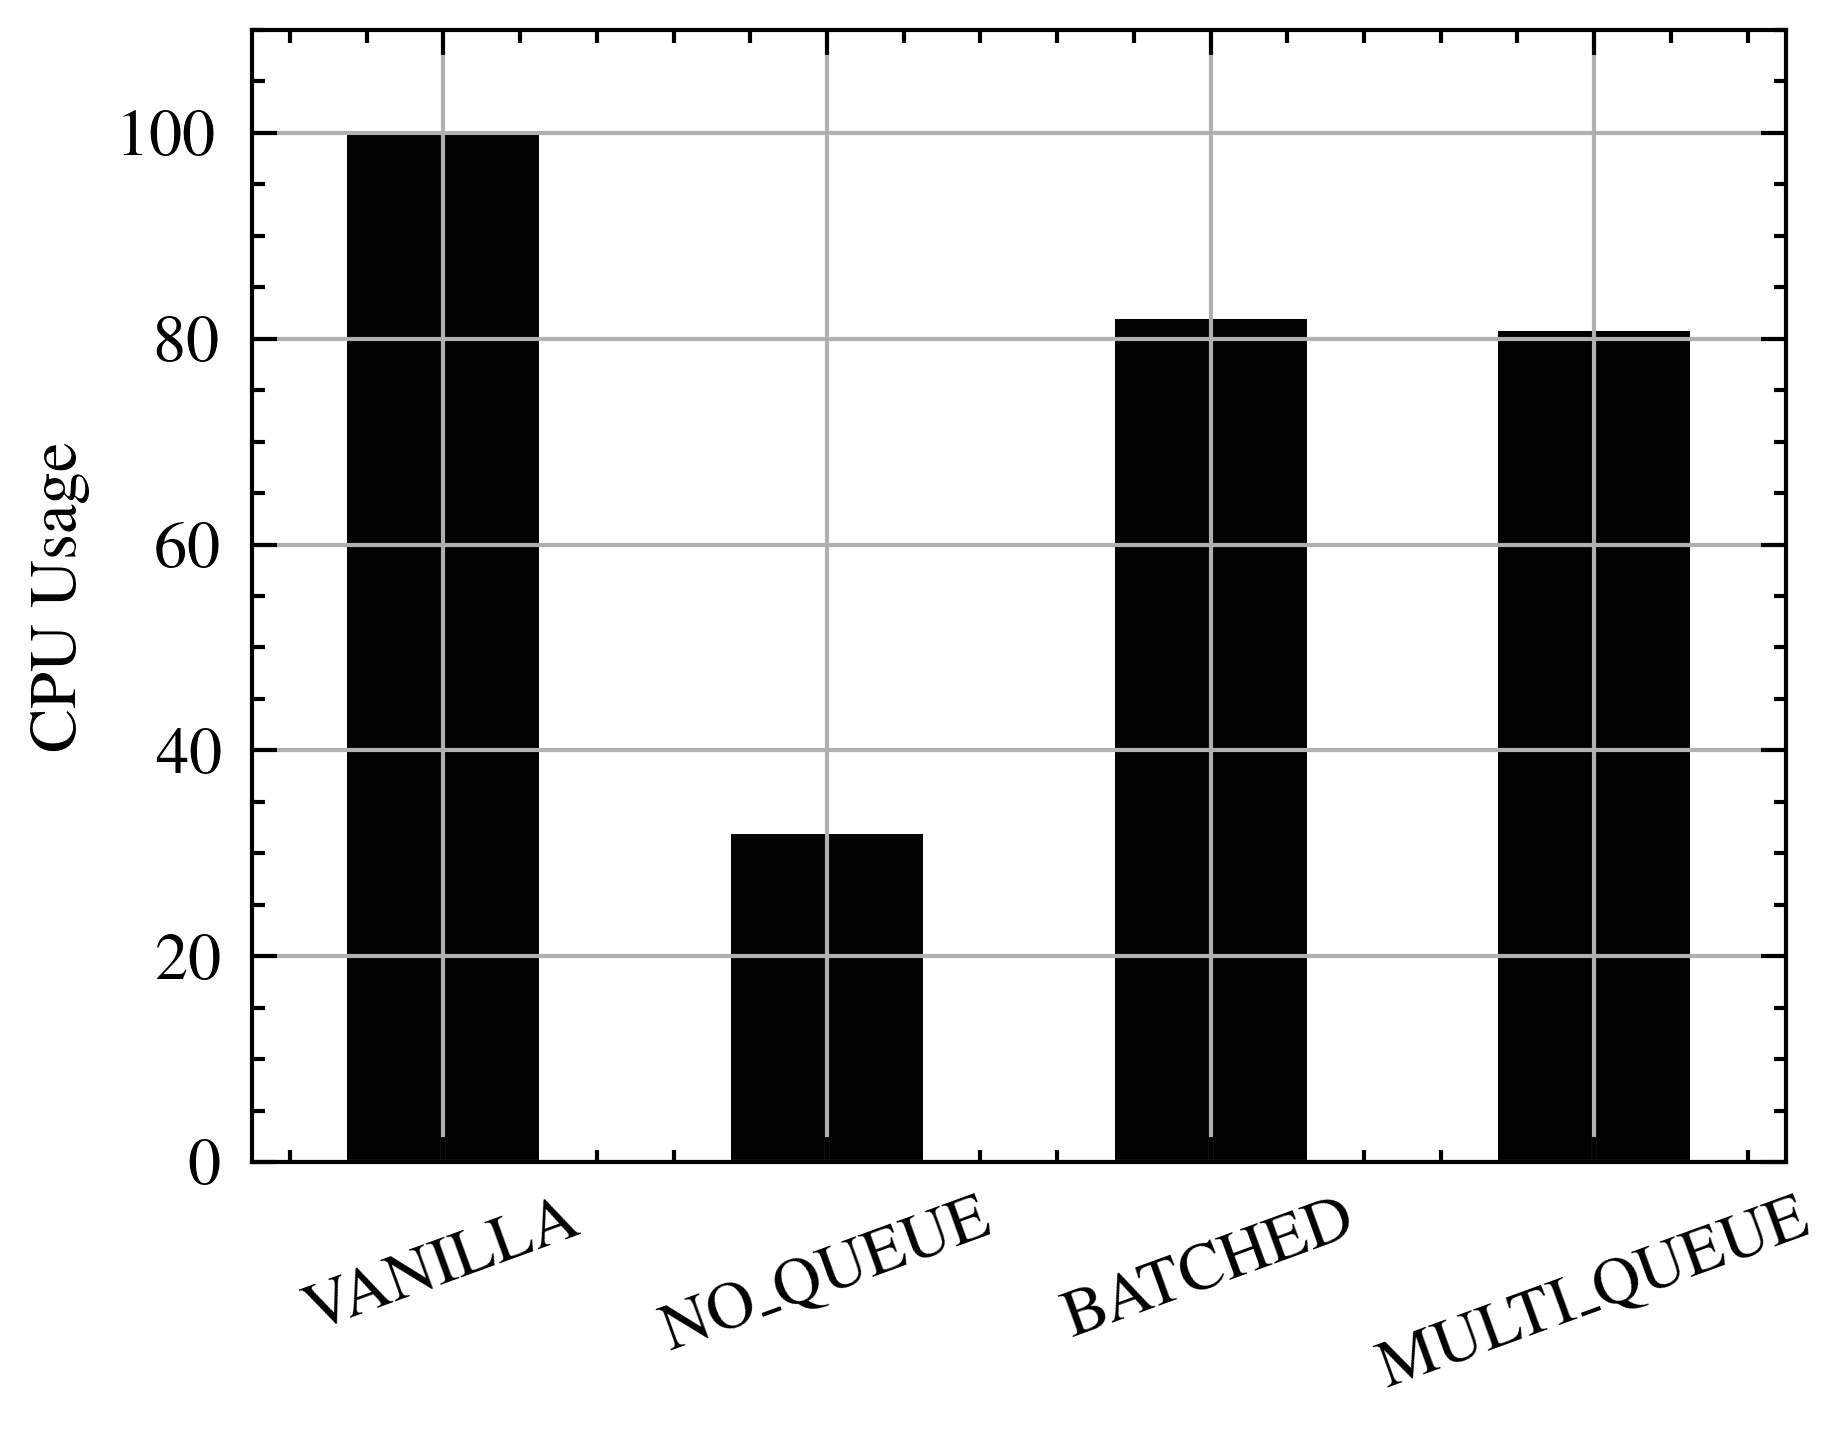

In [57]:
with plt.style.context(['science', 'ieee']):
    df.plot.bar(
        x='variant', y='throughput', legend=None, grid=True,
        ylabel="Throughput in Gbps", ylim=[0, 25], xlabel="",
    )
    plt.xticks(rotation=20)
    plt.savefig('../graphs/all-tp.pdf', dpi=300)
    plt.show()

    df.plot.bar(
        x='variant', y='latency', legend=None, grid=True,
        ylabel="p99 Tail Latency in ms", ylim=[0, 150], xlabel="",
    )
    plt.xticks(rotation=20)
    plt.savefig('../graphs/all-p99.pdf', dpi=300)
    plt.show()

    df.plot.bar(
        x='variant', y='cpu', legend=None, grid=True,
        ylabel="CPU Usage", ylim=[0, 110], xlabel="",
    )
    plt.xticks(rotation=20)
    plt.savefig('../graphs/all-cpu.pdf', dpi=300)
    plt.show()

# Motivation

In [78]:
names = ["total","encrypt_worker","decrypt_worker","encrypt_packet","decrypt_packet","spinlock"]
samples = [146163365911,18106445877,83752110817,4636217711,42962420602,10648123943]
total = samples[0]
total_workers = 18106445877 + 83752110817
total_crypt = 4636217711 + 42962420602
total_spin = 10648123943
names = ['workers', 'crypto', 'spinlocks']
data = [total_workers, total_crypt, total_spin]
spin_part = total_spin * 100 / total_workers
util_part = total_crypt * 100 / total_workers
data = [util_part, spin_part]
names = ['Crypto', 'Spin']

In [79]:
df = pd.DataFrame(data=[data], columns=names)
# df = df * 100 / total
df

,Crypto,Spin
0,46.730132,10.453834


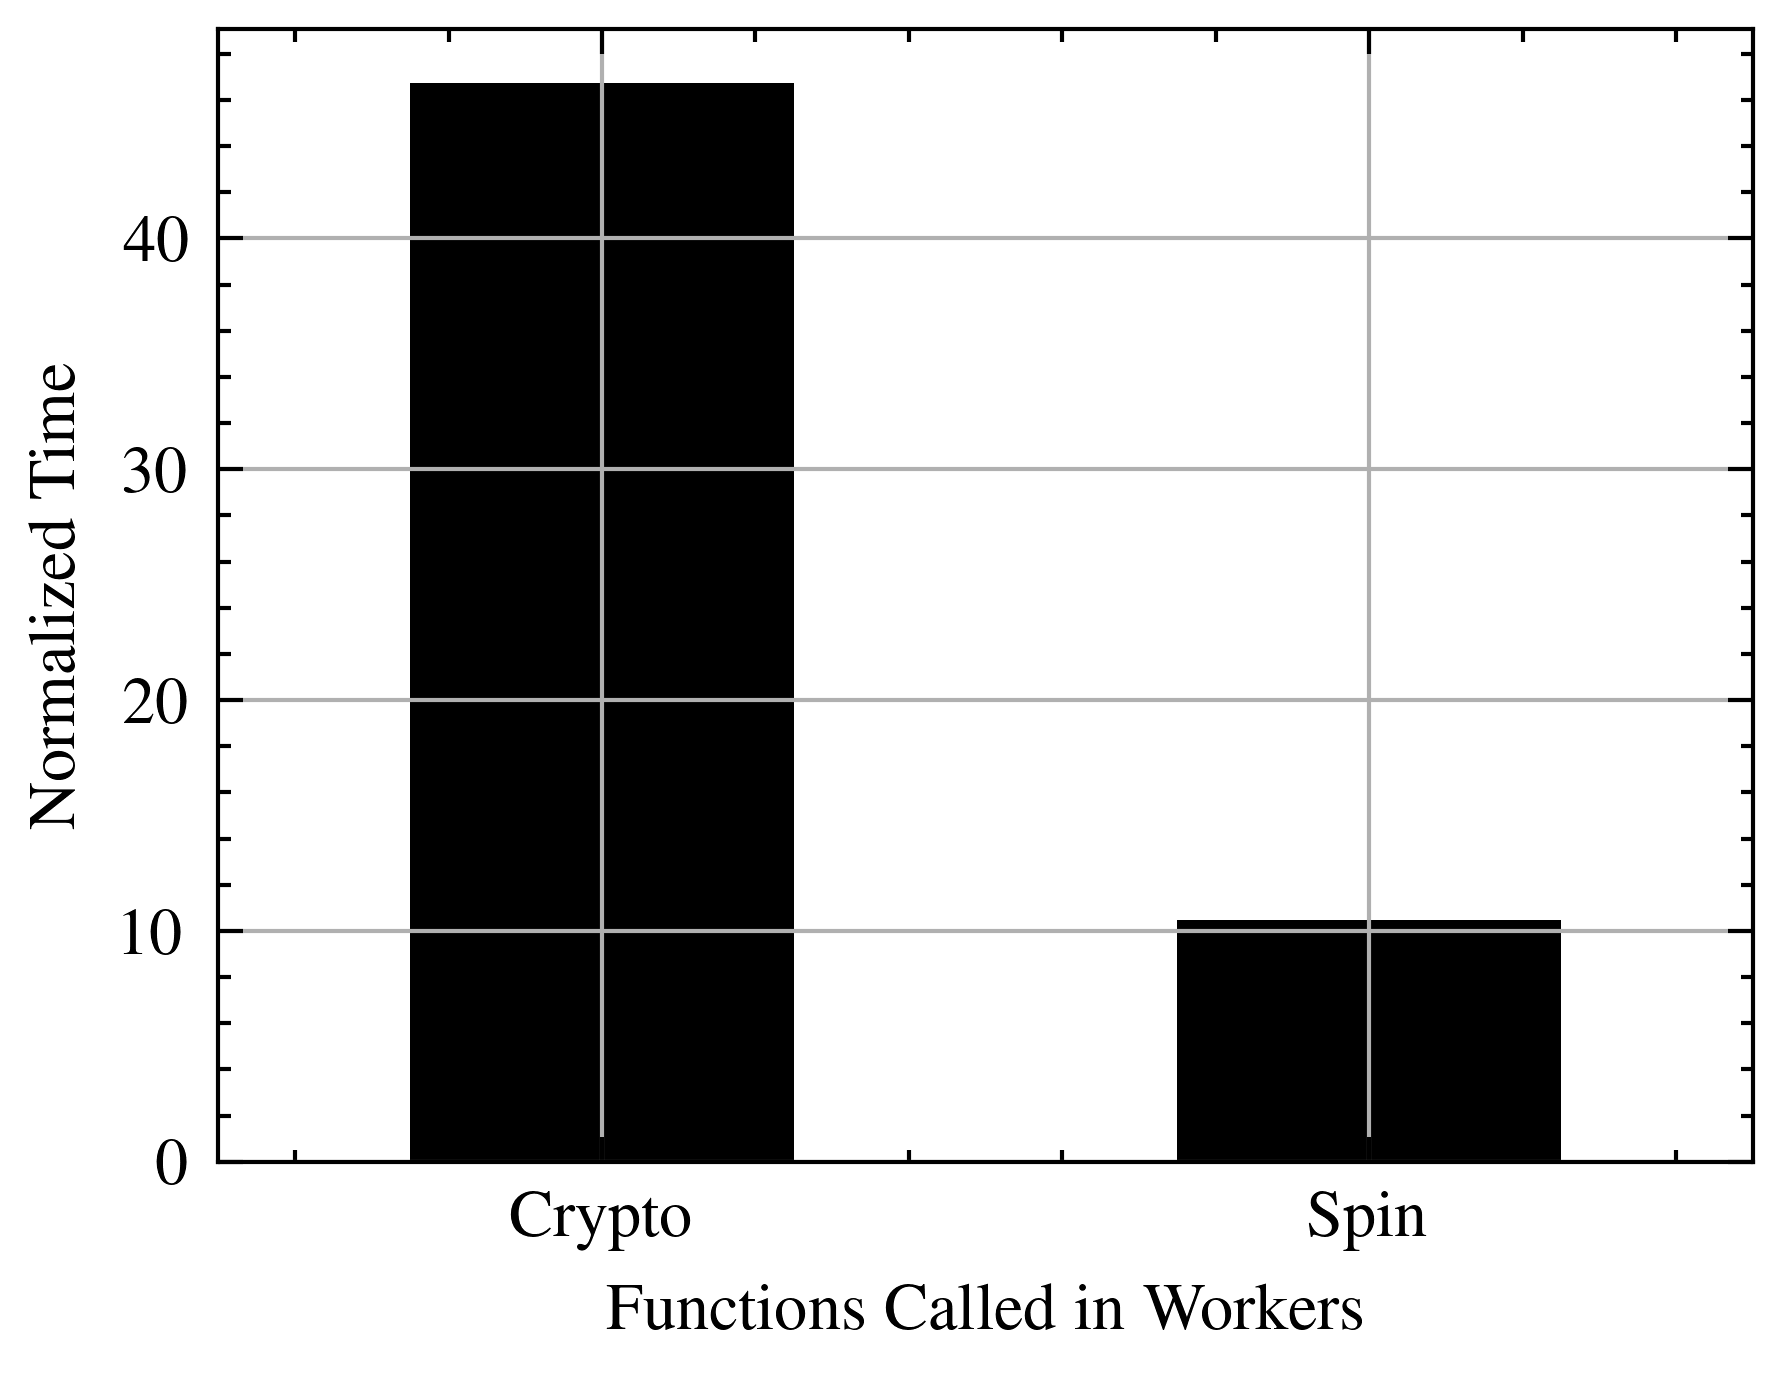

In [82]:
with plt.style.context(['science', 'ieee']):
    df.T.plot.bar(xlabel="Functions Called in Workers", ylabel="Normalized Time", legend=None, grid=True)
    plt.xticks(rotation=0)
    plt.savefig('../graphs/wg-breakdown.pdf', dpi=300)
    plt.show()

In [74]:
vanilla_path = f"{prefix}/{benchmarks[5]}/summary"
vanilla = import_simple(vanilla_path)
vanilla

,throughput,latency,cpu
0,19.237766,124.675,100.0
